In [60]:
import pandas as pd
import numpy as np
import os
import re
import collections
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy import optimize
import pickle
# import plotly.express as px
import datetime
from scipy import stats
# from scipy.stats import zscore
import time
import shap


import torch
from torch import nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import TensorDataset, DataLoader

import wandb

sys.path.append('/well/ludwig/users/dyp502/code/tissue_atlas_code_2023/')
from tissue_atlas_v3_functions import merge_filter_new_tissue_samples

sys.path.append('/well/ludwig/users/dyp502/code/taps_tissue_atlas_Nov2022/')
from taps_tissue_atlas_functions import make_tissue_average_df
from taps_tissue_atlas_functions import plot_region, plot_tissue_sample_atlas, visualise_bed



with open('/well/ludwig/users/dyp502/tissue_atlas_v3/metadata/Atlas_V3_Metadata_New.pickle', 'rb') as f:
    project_metadata = pickle.load(f)

# Load all the variables into memory    
project_dir = project_metadata['project_dir']
atlas_dir = project_metadata['atlas_dir'] 
metadata_dir = project_metadata['metadata_dir']
gene_exp_dir = project_metadata['gene_exp_dir']
intersections_dir = project_metadata['intersections_dir']
id_tissue_map = project_metadata["id_tissue_map"]
tissue_id_map = project_metadata["tissue_id_map"]
blood_cell_types = project_metadata["blood_cell_types"]
somatic_tissue_types = project_metadata["somatic_tissue_types"]
healthy_tissue_types = project_metadata["healthy_tissue_types"]
cancer_tissue_types = project_metadata["cancer_tissue_types"]
diseased_tissue_types = project_metadata["diseased_tissue_types"]
tissues_with_tumour = project_metadata["tissues_with_tumour"]
tissue_order = project_metadata["tissue_order"]
genomic_features = project_metadata["genomic_features"]
sample_outliers = project_metadata["sample_outliers"]
healthy_high_cov_samples = project_metadata["healthy_high_cov_samples"]
genomic_feature_colnames = project_metadata["genomic_feature_colnames"]
genomic_regions_dir = project_metadata['genomic_regions_dir']



use_wandb=False


# data_load_name = "1kb_bins.leave_one_out.test11.remove_zeros."
# model_name = "1kb_bins.exp17.overfit_deeper_net_2pkb.all_tissues_model."
model_name = "1kb_bins.new_data.all_tissues.exp24."
data_load_name = "20kb_upstream_downstream_gene_equal_bins."
save_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/dl_model/"
save=False
load=True
normalise=True
remove_brain =True
use_normalised_TPM = False
# save_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/"





In [62]:
save_dir +  data_load_name +  "data_tensor_filtered.npy"

'/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/dl_model/20kb_upstream_downstream_gene_equal_bins.data_tensor_filtered.npy'

In [63]:
from sklearn.metrics import r2_score
import math


def plot_predictions_for_tissues(tissue_list, test_predictions, tissue_specific_df,
                                true_col="log_tpm", preds_col="predicted_log_tpm",
                                gene_col="gene"):
    
    # Number of tissues to plot
    n = len(tissue_list)
    ncols = 3  # Number of columns for the subplots
    nrows = math.ceil(n / ncols)  # Calculate the required number of rows
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 8 * nrows))
    axes = axes.flatten()  # Flatten the axes array to loop through it
    
    
    
    housekeeping_genes = tissue_specific_df[(tissue_specific_df['specificity'].isin(['Low tissue specificity']))]['Ensembl'].to_list()
    for i, tissue in enumerate(tissue_list):
        print(tissue)
        print(fuzzy_mapping[tissue])
        tissue_df = test_predictions.get(tissue, None)
        
        # No data for this tissue
        if tissue_df is None:
            print(f"No data available for tissue: {tissue}")
            continue
        
        ax = axes[i]
        
        # Identify tissue-specific genes for the current tissue from tissue_specific_df
        specific_genes = tissue_specific_df[(tissue_specific_df['tissue'] == fuzzy_mapping[tissue])&(tissue_specific_df['specificity'].isin(['Tissue enhanced', 'Tissue enriched', 'Group enriched']))]['Ensembl'].to_list()
        


        # Calculate R^2 value for the test set
        test_r2 = r2_score(tissue_df[true_col], tissue_df[preds_col])
        
        # Plot tissue-specific genes
        specific = tissue_df[tissue_df[gene_col].isin(specific_genes)]
        ax.scatter(specific[true_col], specific[preds_col], c='blue', alpha=0.5, label='Tissue-specific genes')

        
        # Plot tissue-specific genes
        specific = tissue_df[tissue_df[gene_col].isin(housekeeping_genes)]
        ax.scatter(specific[true_col], specific[preds_col], c='orange', alpha=0.5, label='Housekeeping genes')
        
        # Plot non-specific genes
        non_specific = tissue_df[~tissue_df[gene_col].isin(specific_genes+housekeeping_genes)]
        ax.scatter(non_specific[true_col], non_specific[preds_col], c='gray', alpha=0.5, label='Other genes')

        # Add a diagonal line
        min_val = min(tissue_df[true_col].min(), tissue_df[preds_col].min())
        max_val = max(tissue_df[true_col].max(), tissue_df[preds_col].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--')
        
        # Annotate with R^2 value
        ax.annotate(f'Test R^2 = {test_r2:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', color='red')
        
        # Label and title
        ax.set_xlabel('True logTPM')
        ax.set_ylabel('Predicted logTPM')
        ax.set_title(f"Predicted vs True logTPM for {tissue}")
        ax.legend(loc='lower right')
        
    # Remove any unused subplots
    for i in range(n, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()
    
    
    
    
    
# Original TISSUE_COLOR_MAP
TISSUE_COLOR_MAP = {
    'breast': '#1f77b4',
    'colon': '#ff7f0e',
    'esophagus': '#2ca02c',
    'heart muscle': '#d62728',
    'kidney': '#9467bd',
    'liver': 'b',  # Aligned with TISSUE_COLOR_MAP2
    'lung': 'g',  # Aligned with TISSUE_COLOR_MAP2
    'ovary': '#7f7f7f',
    'pancreas': 'c',  # Aligned with TISSUE_COLOR_MAP2
    'prostate': 'r',  # Aligned with TISSUE_COLOR_MAP2
    'spleen': 'y',  # Aligned with TISSUE_COLOR_MAP2
    'stomach': 'm',  # Aligned with TISSUE_COLOR_MAP2
    'memory CD4 T-cell': '#ff9896',
    'neutrophil': '#c49c94',
    'NK-cell': '#f7b6d2',
    'naive B-cell': '#c5b0d5',
    'memory CD8 T-cell': '#dbdb8d',
    'eosinophil': '#9edae5',
    'classical monocyte': '#8ca252',
    'midbrain': '#ffd700'  # New addition
}

# Original TISSUE_COLOR_MAP2
TISSUE_COLOR_MAP2 = {
    'Liver': 'b',
    'Lung': 'g',
    'Prostate': 'r',
    'Pancreas': 'c',
    'Stomach': 'm',
    'Spleen': 'y',
    'Kidney': 'k',
    'Esophagus': '#ff9900',
    'Heart': '#3366cc',
    'Colon': '#0099cc',
    'Breast': '#99cc33',
    'Ovary': '#9933ff',
    'NK-cells': '#ff33cc',
    'CD8-T-cells': '#993366',
    'CD4-T-cells': '#99cc99',
    'Eosinophils': '#cc9900',
    'Monocytes': '#0099cc',
    'Brain': '#336699',
    'B-cells': '#33cccc',
    'Neutrophils': '#666699'
}




def plot_metrics(metrics_df, plot_mae_mse=False):
    """
    This function takes a DataFrame containing ML metrics and plots two subplots:
    1) A barplot representing the number of training and test samples for each tissue.
    2) A scatterplot representing the R2 score for each tissue, annotated with the score.
    Additionally, can optionally add lines for MSE and MAE on a secondary y-axis.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # First subplot
    sns.barplot(x='tissue', y='train_samples', data=metrics_df, ax=axes[0], dodge=0.2, alpha=0.9, label='Train', color='#808080', edgecolor='#808080', linewidth=1.2, hatch='--')
    sns.barplot(x='tissue', y='test_samples', data=metrics_df, ax=axes[0], dodge=0.2, alpha=0.9, label='Test', color='#8B0000', edgecolor='#8B0000', linewidth=1.2, hatch='--')
    axes[0].set_title('Train/Test Samples per Tissue')
    axes[0].legend()
    axes[0].tick_params(axis='x', rotation=90)
    
    # Second subplot
    sns.scatterplot(x='tissue', y='r2', data=metrics_df, ax=axes[1], hue='tissue', palette=TISSUE_COLOR_MAP, s=100)
    axes[1].set_title('R2 Score per Tissue')
    axes[1].set_ylim(0, 1)
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].grid(True)
    
    for i, row in metrics_df.iterrows():
        axes[1].text(row['tissue'], row['r2'], f"{row['r2']:.2f}", ha='right', va='bottom')
    
    if plot_mae_mse:
        ax2 = axes[1].twinx()  # Instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('MSE, MAE')  # Label for MSE and MAE
        sns.lineplot(x='tissue', y='mse', data=metrics_df, ax=ax2, color='orange', label='MSE')
        sns.lineplot(x='tissue', y='mae', data=metrics_df, ax=ax2, color='purple', label='MAE')
        ax2.legend(loc='upper right')
        
    axes[1].legend(title='Tissue', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


In [64]:

    
    
    
from matplotlib.lines import Line2D



def plot_metrics_dl(metrics_df, plot_mae_mse=False):
    """
    Function to plot training and testing metrics, now including annotation for sample sizes.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    train_samples = metrics_df.iloc[0]['train_samples']
    test_samples = metrics_df.iloc[0]['test_samples']
    
    # First subplot for Train/Test Samples
    sns.barplot(x='Tissue', y='train_samples', data=metrics_df, ax=axes[0], dodge=0.2, alpha=0.9, label='Train', color='#808080', edgecolor='#808080', linewidth=1.2, hatch='--')
    sns.barplot(x='Tissue', y='test_samples', data=metrics_df, ax=axes[0], dodge=0.2, alpha=0.9, label='Test', color='#8B0000', edgecolor='#8B0000', linewidth=1.2, hatch='--')
    axes[0].set_title('Train/Test Samples per Tissue')
    axes[0].legend()
    axes[0].tick_params(axis='x', rotation=90)
    
    # Add annotations for train and test sample sizes
    axes[0].text(0.5, 0.5, f'Train Samples: {train_samples}\nTest Samples: {test_samples}', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    if 'Lung' in list(metrics_df['Tissue']):
        tissue_color_map = TISSUE_COLOR_MAP2
    else:
        tissue_color_map = TISSUE_COLOR_MAP
        
    subset_color_map = {k: v for k, v in tissue_color_map.items() if k in list(metrics_df['Tissue'])}
    
    # Second subplot for Test R2 and Train R2
    sns.scatterplot(x='Tissue', y='Test R2', data=metrics_df, ax=axes[1], hue='Tissue', palette=subset_color_map, s=100, label='Test R2')
    sns.scatterplot(x='Tissue', y='Train R2', data=metrics_df, ax=axes[1], hue='Tissue', palette=subset_color_map, s=100, marker='X', label='Train R2')
    axes[1].set_title('Train/Test R2 Score per Tissue')
    axes[1].set_ylim(0, 1)
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].grid(True)
    
    # Creating custom legend for Test R2 and Train R2
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Test R2'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray', markersize=10, label='Train R2')
    ]
    axes[1].legend(handles=legend_elements, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    for i, row in metrics_df.iterrows():
        axes[1].text(row['Tissue'], row['Test R2'], f"{row['Test R2']:.2f}", ha='right', va='bottom')
        axes[1].text(row['Tissue'], row['Train R2'], f"{row['Train R2']:.2f}", ha='right', va='top')
    
    if plot_mae_mse:
        ax2 = axes[1].twinx()  # Instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('MSE, MAE')  # Label for MSE and MAE
        sns.lineplot(x='Tissue', y='Test MAE', data=metrics_df, ax=ax2, color='orange', label='Test MAE')
        sns.lineplot(x='Tissue', y='Train MAE', data=metrics_df, ax=ax2, color='purple', label='Train MAE')
        ax2.legend(loc='upper right')
        
    plt.tight_layout()
    plt.show()
    


def plot_predictions_for_tissues_dl(tissue_list, predictions_df, tissue_specific_df):
    # Number of tissues to plot
    n = len(tissue_list)
    ncols = 3  # Number of columns for the subplots
    nrows = math.ceil(n / ncols)  # Calculate the required number of rows
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 8 * nrows))
    axes = axes.flatten()  # Flatten the axes array for easier looping
    
    # Get list of housekeeping genes
    housekeeping_genes = tissue_specific_df[tissue_specific_df['specificity'].isin(['Low tissue specificity'])]['Ensembl'].to_list()
    
    for i, tissue in enumerate(tissue_list):
        ax = axes[i]
        
        # Filter the DataFrame for the specific tissue
        tissue_df = predictions_df[predictions_df['tissue_x'] == tissue]

        # No data for this tissue
        if tissue_df.empty:
            print(f"No data available for tissue: {tissue}")
            continue
        
        # Identify tissue-specific genes for the current tissue from tissue_specific_df
        specific_genes = tissue_specific_df[tissue_specific_df['tissue'] == tissue]['Ensembl'].to_list()

        if len(specific_genes)==0: # if no specific genes, may be because we're not using rna_seq_tissue names (which are lower case), so need mapping
            rna_seq_tissue_mapping = predictions_df.set_index('tissue_x')['rna_seq_tissue'].to_dict()
            specific_genes = tissue_specific_df[tissue_specific_df['tissue'] == rna_seq_tissue_mapping[tissue]]['Ensembl'].to_list()
        
        # Calculate R^2 value for the test set
        test_r2 = r2_score(tissue_df['logTPM'], tissue_df['model_preds'])
        
        # Plot tissue-specific genes
        specific = tissue_df[tissue_df['core_gene'].isin(specific_genes)]
        ax.scatter(specific['logTPM'], specific['model_preds'], c='blue', alpha=0.5, label='Tissue-specific genes')
        
        # Plot housekeeping genes
        housekeeping = tissue_df[tissue_df['core_gene'].isin(housekeeping_genes)]
        ax.scatter(housekeeping['logTPM'], housekeeping['model_preds'], c='orange', alpha=0.5, label='Housekeeping genes')
        
        # Plot other genes
        other_genes = tissue_df[~tissue_df['core_gene'].isin(specific_genes + housekeeping_genes)]
        ax.scatter(other_genes['logTPM'], other_genes['model_preds'], c='gray', alpha=0.5, label='Other genes')
        
        # Add diagonal line for reference
        min_val = min(tissue_df['logTPM'].min(), tissue_df['model_preds'].min())
        max_val = max(tissue_df['logTPM'].max(), tissue_df['model_preds'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--')
        
        # Annotate the plot with the R^2 value
        ax.annotate(f'Test R^2 = {test_r2:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', color='red')
        
        # Set labels and title
        ax.set_xlabel('True logTPM')
        ax.set_ylabel('Predicted logTPM')
        ax.set_title(f"Predicted vs True logTPM for {tissue}")
        ax.legend(loc='lower right')
    
    # Remove unused subplot axes
    for i in range(n, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()
    
    

In [65]:

# ### Load data
# data_tensor_filtered = np.load(save_dir +  data_load_name +  "data_tensor_filtered.npy")
# rna_seq_values = np.load(save_dir + data_load_name +  "rna_seq_values.npy")
# rna_seq_values_df = pd.read_csv(save_dir +  data_load_name + f"gene_tissue_combinations_rnaseq.csv",sep='\t')



# if remove_brain:
#     rna_seq_values = rna_seq_values[rna_seq_values_df['tissue_x']!='Brain']
#     data_tensor_filtered = data_tensor_filtered[rna_seq_values_df['tissue_x']!='Brain']
#     rna_seq_values_df = rna_seq_values_df.loc[rna_seq_values_df['tissue_x']!='Brain']
#     rna_seq_values_df = rna_seq_values_df.reset_index()



batch_size = 32
### Store model predictions
predictions_dict = {}

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, r2_score


### Model training
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1,kernel_size=(3, 3)):
        super(ResidualBlock, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = self.layer1(x)
        # print("Output shape after layer1:", out.shape)  # Debug print
        # print("Shortcut shape:", self.shortcut(x).shape)  # Debug print
        
        # out += self.shortcut(x)  # This is the residual connection
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            m.bias.data.zero_()





n_epigenetic_cols = 3
n_1kb_bins = 60



# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()

#         self.layer1 = ResidualBlock(1, 16, kernel_size=(3, 5))  # Assuming 1 channel input. Adjust if needed.
#         self.layer2 = ResidualBlock(16, 32, kernel_size=(3, 5))
#         self.layer3 = ResidualBlock(32, 64, kernel_size=(3, 5))

#         self.fc1 = nn.Linear(64 * n_epigenetic_cols * n_1kb_bins, 128)  # Adjust sizes based on the output of the Conv layers
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 1)

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
        
#         out = out.view(out.size(0), -1)  # Flatten
#         out = F.relu(self.fc1(out))
#         out = F.relu(self.fc2(out))
#         out = self.fc3(out)
#         return out



### Make bigger network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Add more Residual Blocks to increase model complexity
        self.layer1 = ResidualBlock(1, 32, kernel_size=(3, 5))  # Increased channels to 32
        self.layer2 = ResidualBlock(32, 64, kernel_size=(3, 5))  # Increased channels to 64
        self.layer3 = ResidualBlock(64, 128, kernel_size=(3, 5))  # Increased channels to 128
        self.layer4 = ResidualBlock(128, 256, kernel_size=(3, 5))  # Added one more layer

        # Increase the size of each fully connected layer
        self.fc1 = nn.Linear(256 * n_epigenetic_cols * n_1kb_bins, 512)  # Changed from 128 to 512
        self.fc2 = nn.Linear(512, 256)  # Changed from 64 to 256
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)  # Forward through the new layer
        
        out = out.view(out.size(0), -1)  # Flatten
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out







In [66]:
model_name = "1kb_bins.new_data.leave_one_out.no_brain.just_mC.exp28." # after switching order for - strand genes
data_load_name = "20kb_upstream_downstream_gene_equal_bins."
save_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/dl_model/"
save=False
load=True
normalise=True
remove_brain =True
use_normalised_TPM = False
# save_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/"




### Load data
data_tensor_filtered = np.load(save_dir +  data_load_name +  "data_tensor_filtered.npy")
# rna_seq_values = np.load(save_dir + data_load_name +  "rna_seq_values.npy")
# rna_seq_values_df = pd.read_csv(save_dir +  data_load_name + f"gene_tissue_combinations_rnaseq.csv",sep='\t')

In [67]:
data_tensor_filtered

array([[[0.05979545, 0.07496743, 0.74074958, ..., 0.77644835,
         1.02633978, 1.07096324],
        [0.21936523, 0.30194979, 1.54846045, ..., 1.85815254,
         1.44522975, 1.31619138],
        [3.76036653, 3.658735  , 1.17892572, ..., 0.83337853,
         0.56913656, 0.58946286]],

       [[0.1213553 , 0.10914797, 0.74321148, ..., 1.05198532,
         1.13097398, 1.14892595],
        [0.58005669, 0.43504252, 2.36856483, ..., 2.36252257,
         1.83080393, 1.40180367],
        [3.38357388, 3.45029224, 1.45827269, ..., 0.65765239,
         0.51468448, 0.53374687]],

       [[0.1392707 , 0.06981436, 0.38308394, ..., 1.05974623,
         1.1456716 , 1.17073317],
        [0.58579012, 0.6518473 , 1.80099302, ..., 2.07519265,
         1.75737035, 1.36476633],
        [3.3546272 , 3.5362167 , 2.5231384 , ..., 0.66901397,
         0.49698181, 0.47786712]],

       ...,

       [[0.55751952, 1.05235933, 1.1216369 , ..., 0.91710311,
         0.55092165, 0.78844476],
        [1.20406889, 

In [68]:
data_tensor_filtered.shape

(207640, 3, 60)

### Model performance

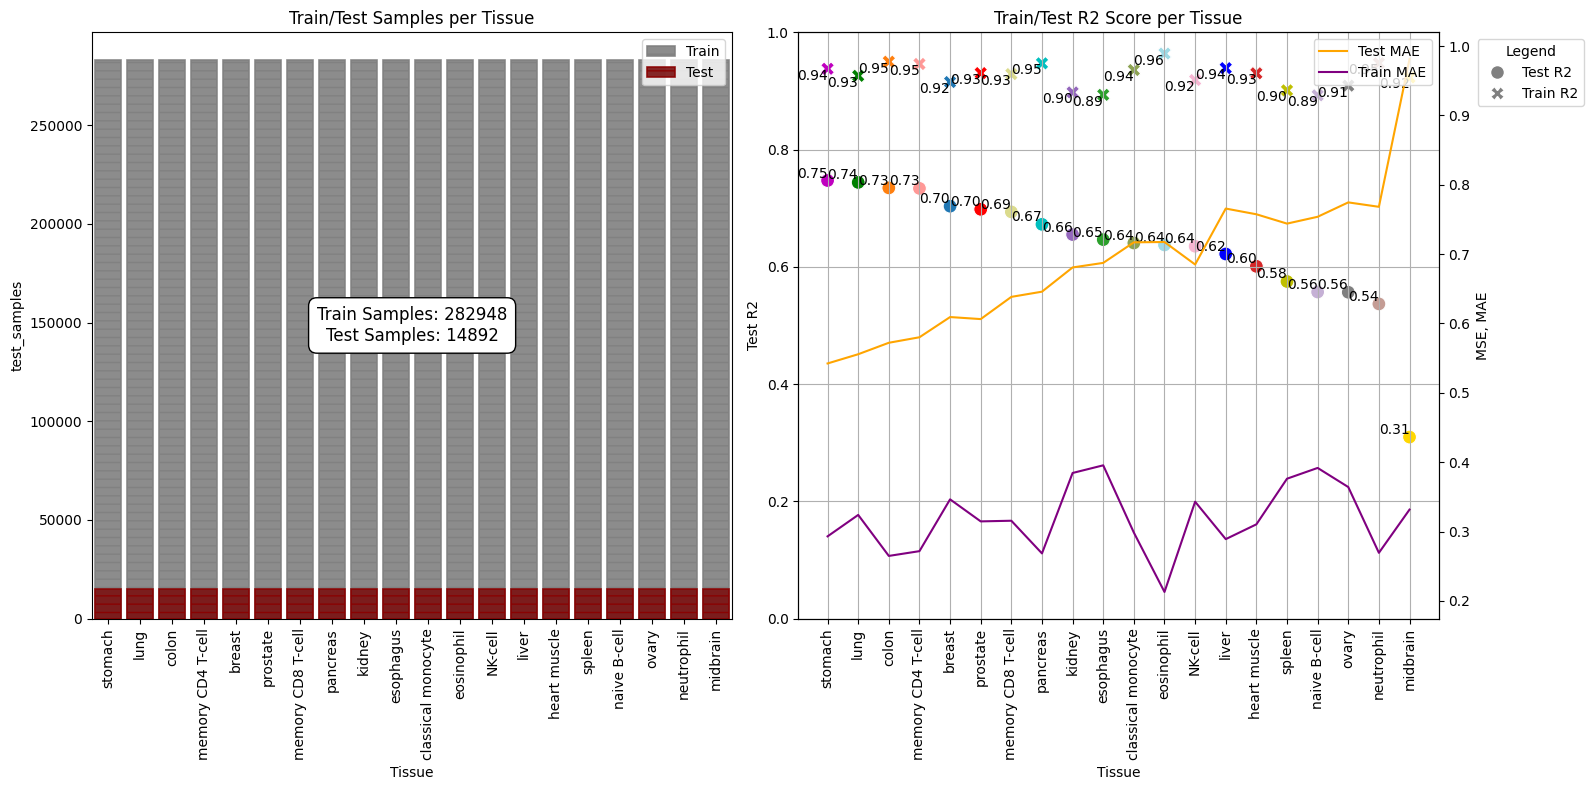

In [75]:
# model_name = "1kb_bins.leave_one_out.test12.exp2_overfit.lung"
model_name = "1kb_bins.leave_one_out.exp14.overfit_deeper_net"
models_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/dl_model/"

metrics_df = pd.read_csv(models_dir + f"{model_name}.tissue_results.csv",sep='\t').sort_values(by='Test R2',ascending=False)
plot_metrics_dl(metrics_df,plot_mae_mse=True)#.head()
test_predictions = pd.read_csv(models_dir + f"{model_name}.model_predictions_df.csv")
# plot_predictions_for_tissues_dl(['Lung','Liver','Pancreas','Kidney'], test_predictions, tissue_specific_df)

1kb_bins.new_data.leave_one_out.exp22




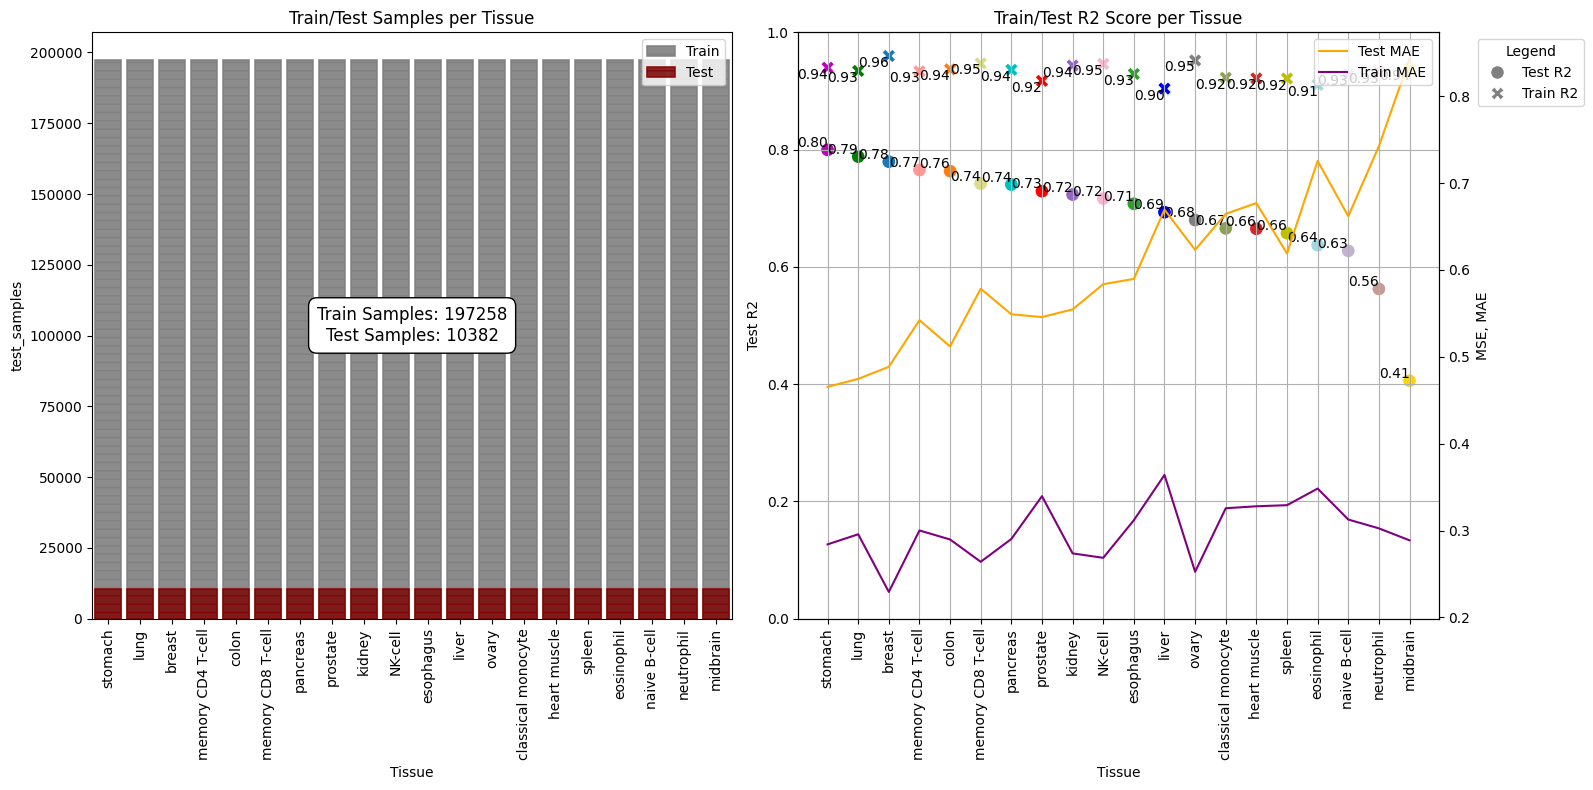

2kb_bins.new_data.leave_one_out.exp23




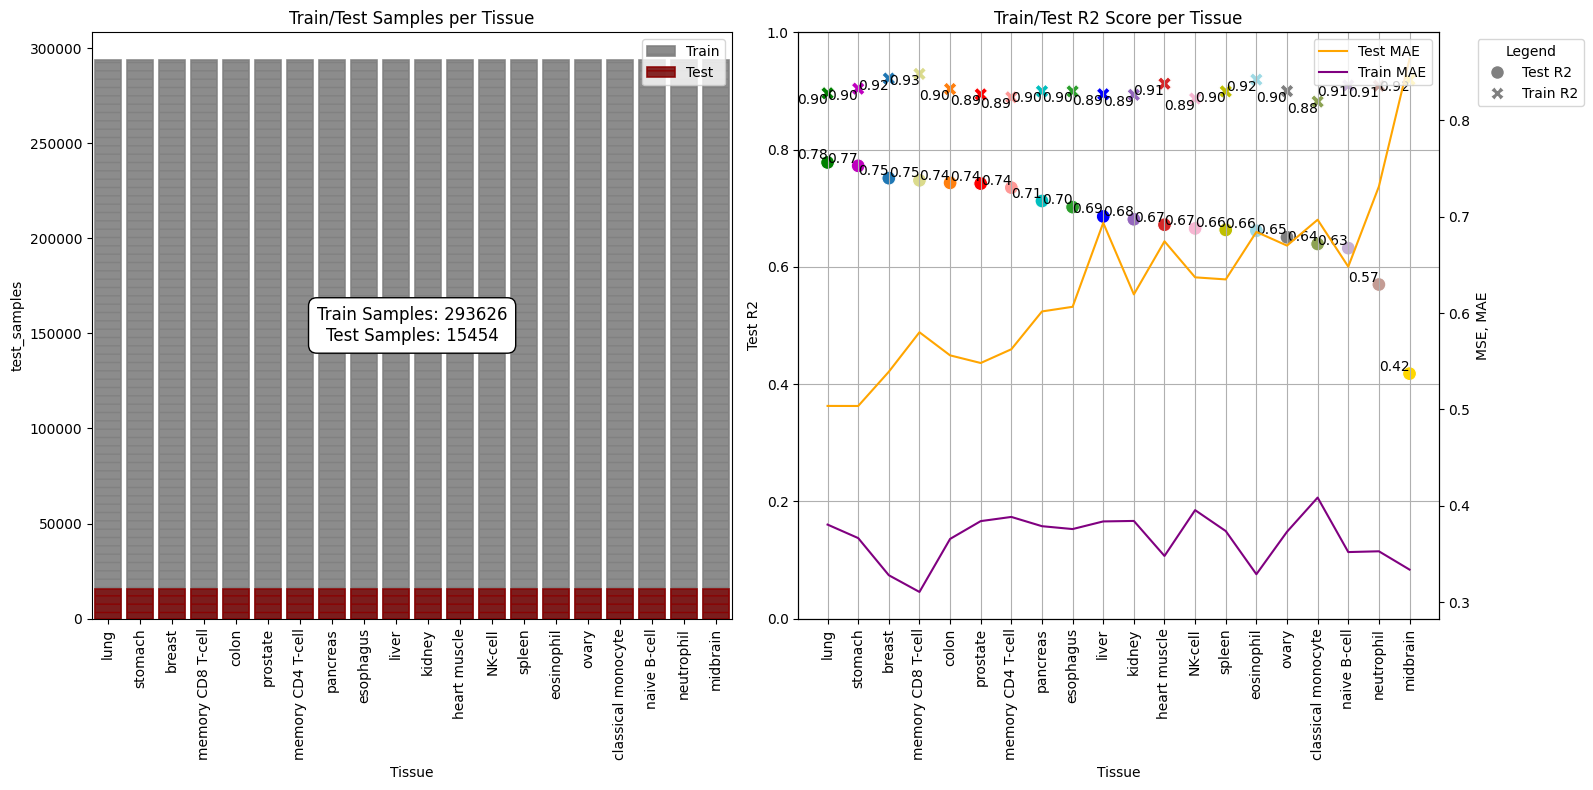

1kb_bins.new_data.leave_one_out.no_brain.exp26




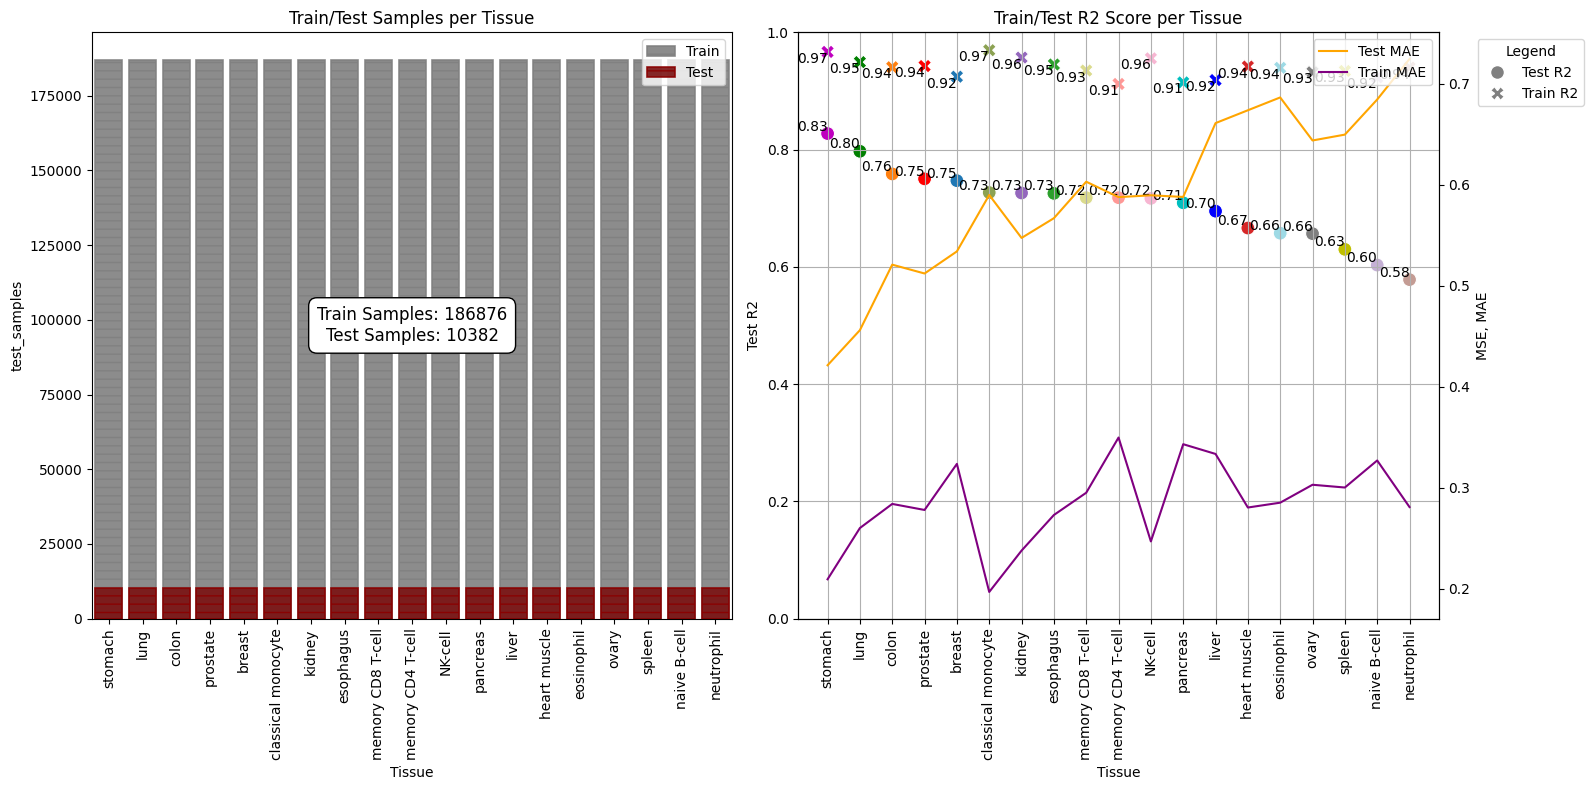

2kb_bins.new_data.leave_one_out.no_brain.exp27




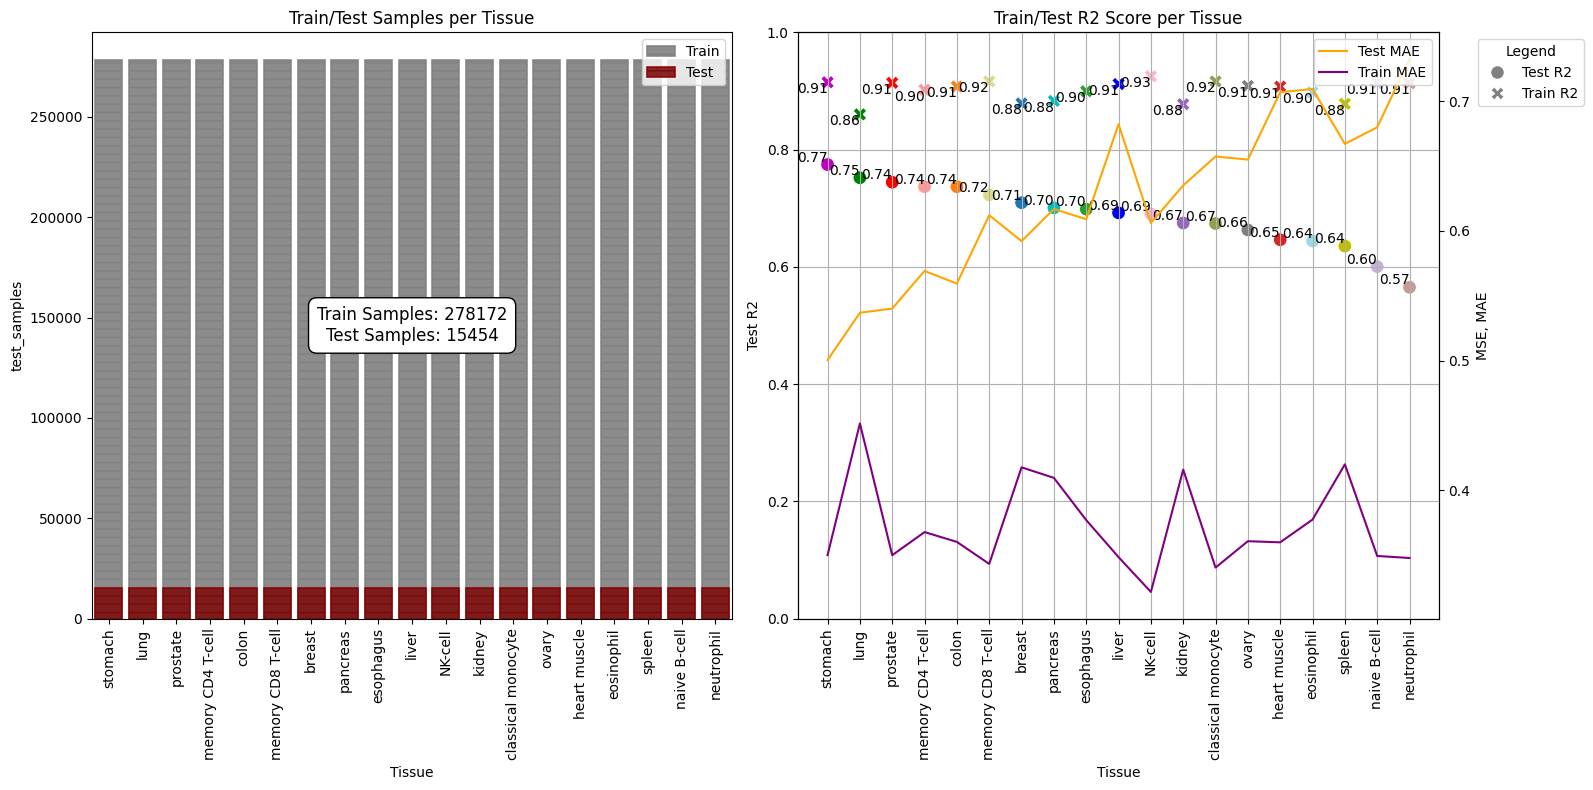

1kb_bins.new_data.leave_one_out.no_brain.mC_hmC.exp31




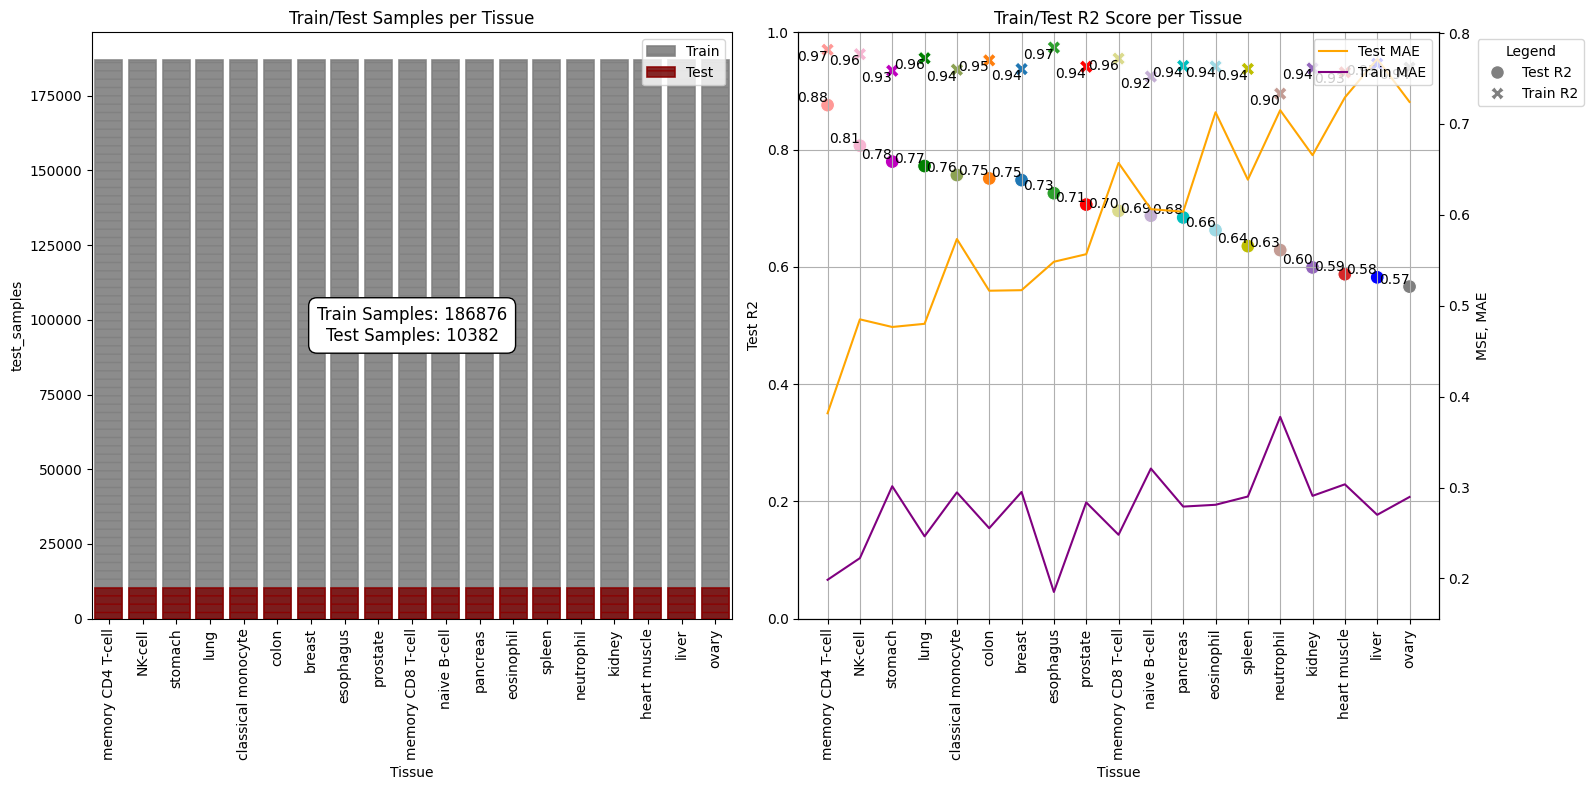

1kb_bins.new_data.leave_one_out.no_brain.tissue_specific.exp32




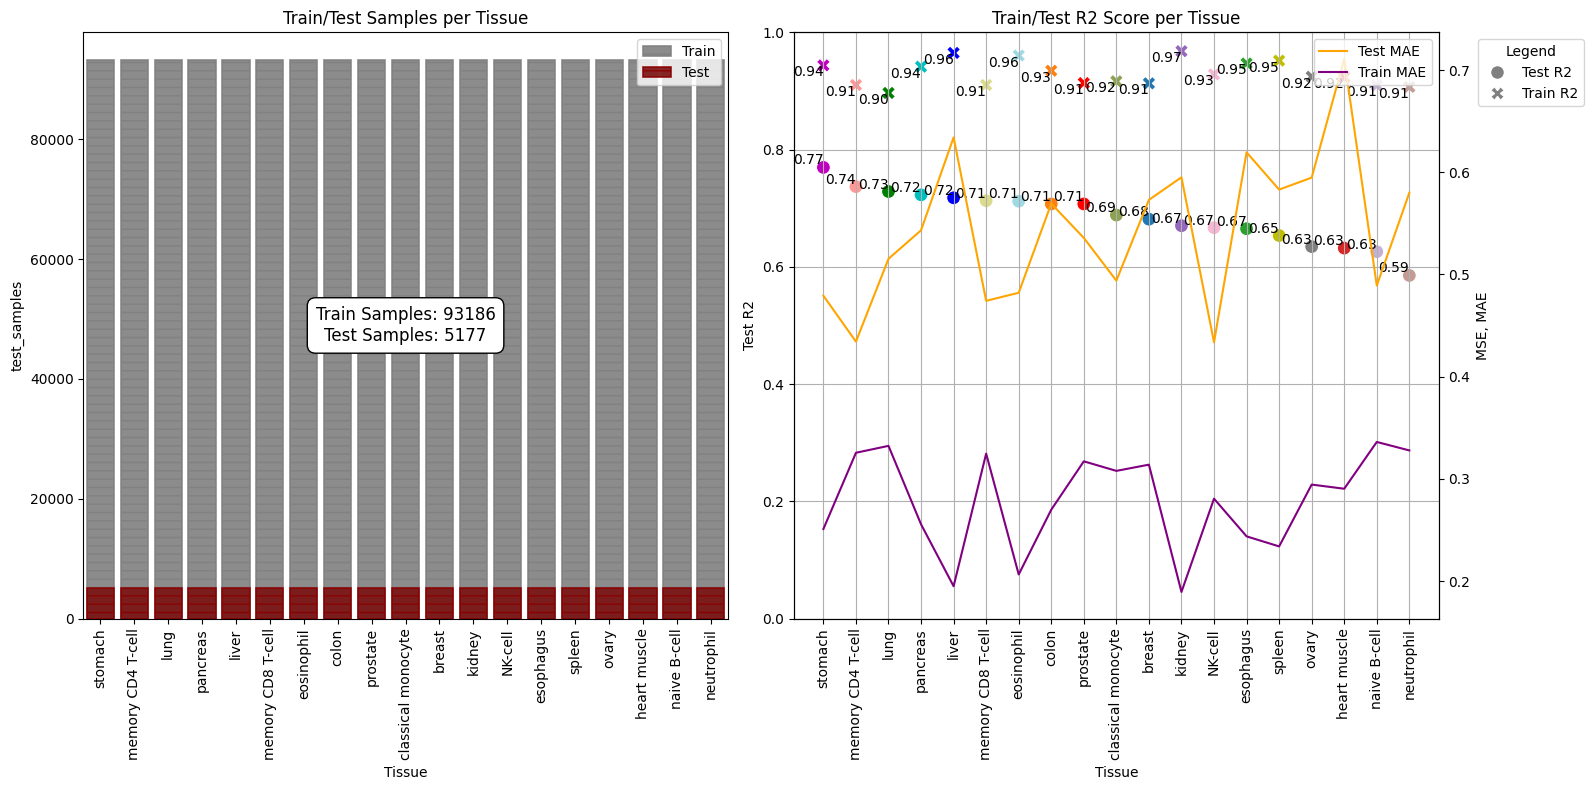

In [76]:
# Defining the directory where the models are stored.
models_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/dl_model/"

# List of model names to iterate through.
model_names = [
    "1kb_bins.new_data.leave_one_out.exp22",
    "2kb_bins.new_data.leave_one_out.exp23",
    "1kb_bins.new_data.leave_one_out.no_brain.exp26",
    "2kb_bins.new_data.leave_one_out.no_brain.exp27",
#     "1kb_bins.new_data.leave_one_out.no_brain.just_mC.exp28",
#     "1kb_bins.new_data.leave_one_out.no_brain.just_hmC.exp29",
#     "1kb_bins.new_data.leave_one_out.no_brain.just_umC.exp30",
    "1kb_bins.new_data.leave_one_out.no_brain.mC_hmC.exp31",
    "1kb_bins.new_data.leave_one_out.no_brain.tissue_specific.exp32",
#                         '1kb_bins.new_data.all_tissues.housekeeping.exp35.',
#                    '1kb_bins.new_data.all_tissues.TESTING.exp39.',
#                '1kb_bins.new_data.all_tissues.TESTING.exp38.',
#                '1kb_bins.new_data.all_tissues.TESTING.exp40.',
#                '1kb_bins.new_data.all_tissues.TESTING.exp41.'
]

# Function to plot metrics, assuming it's already defined as plot_metrics_dl(metrics_df, plot_mae_mse=True)
# Define plot_metrics_dl function here if it's not already defined.

# Iterating through each model, loading its metrics, and plotting.
for model_name in model_names:
    print(f"{model_name}\n\n")
    metrics_file = f"{models_dir}{model_name}.tissue_results.csv"
    predictions_file = f"{models_dir}{model_name}.model_predictions_df.csv"

    # Loading and sorting the metrics data frame.
    metrics_df = pd.read_csv(metrics_file, sep='\t').sort_values(by='Test R2', ascending=False)
    
    # Plotting the metrics.
    plot_metrics_dl(metrics_df, plot_mae_mse=True)

In [77]:
metrics_df

,Unnamed: 0,train_samples,test_samples,Tissue,Train MAE,Test MAE,Train R2,Test R2
11,11,93186,5177,stomach,0.250979,0.479242,0.943624,0.769601
12,12,93186,5177,memory CD4 T-cell,0.325569,0.434291,0.910147,0.736874
6,6,93186,5177,lung,0.332316,0.515362,0.896650,0.728503
8,8,93186,5177,pancreas,0.255563,0.543249,0.941380,0.722807
5,5,93186,5177,liver,0.194999,0.634096,0.964914,0.717786
16,16,93186,5177,memory CD8 T-cell,0.324722,0.474241,0.910208,0.712851
17,17,93186,5177,eosinophil,0.206501,0.482095,0.960411,0.711973
1,1,93186,5177,colon,0.269850,0.569353,0.934504,0.707318
9,9,93186,5177,prostate,0.317183,0.535782,0.913462,0.707303
18,18,93186,5177,classical monocyte,0.307848,0.493997,0.916468,0.688362


### R-squared plot for best model

- Figure for thesis

In [79]:
tissue_name_mapping = {
    'stomach': 'Stomach',
    'memory CD4 T-cell': 'CD4-T-cells',
    'lung': 'Lung',
    'pancreas': 'Pancreas',
    'liver': 'Liver',
    'memory CD8 T-cell': 'CD8-T-cells',
    'eosinophil': 'Eosinophils',
    'colon': 'Colon',
    'prostate': 'Prostate',
    'classical monocyte': 'Monocytes',
    'breast': 'Breast',
    'kidney': 'Kidney',
    'NK-cell': 'NK-cells',
    'esophagus': 'Esophagus',
    'spleen': 'Spleen',
    'ovary': 'Ovary',
    'heart muscle': 'Heart',
    'naive B-cell': 'B-cells',
    'neutrophil': 'Neutrophils'
}

In [80]:
metrics_df['Tissue_atlas_name'] = metrics_df['Tissue'].map(tissue_name_mapping)

In [82]:
metrics_df

,Unnamed: 0,train_samples,test_samples,Tissue,Train MAE,Test MAE,Train R2,Test R2,Tissue_atlas_name
11,11,93186,5177,stomach,0.250979,0.479242,0.943624,0.769601,Stomach
12,12,93186,5177,memory CD4 T-cell,0.325569,0.434291,0.910147,0.736874,CD4-T-cells
6,6,93186,5177,lung,0.332316,0.515362,0.896650,0.728503,Lung
8,8,93186,5177,pancreas,0.255563,0.543249,0.941380,0.722807,Pancreas
5,5,93186,5177,liver,0.194999,0.634096,0.964914,0.717786,Liver
16,16,93186,5177,memory CD8 T-cell,0.324722,0.474241,0.910208,0.712851,CD8-T-cells
17,17,93186,5177,eosinophil,0.206501,0.482095,0.960411,0.711973,Eosinophils
1,1,93186,5177,colon,0.269850,0.569353,0.934504,0.707318,Colon
9,9,93186,5177,prostate,0.317183,0.535782,0.913462,0.707303,Prostate
18,18,93186,5177,classical monocyte,0.307848,0.493997,0.916468,0.688362,Monocytes


In [83]:
# model_name = "1kb_bins.new_data.leave_one_out.no_brain.mC_hmC.exp31"
model_name = "1kb_bins.new_data.leave_one_out.no_brain.tissue_specific.exp32"

print(f"{model_name}\n\n")
metrics_file = f"{models_dir}{model_name}.tissue_results.csv"
predictions_file = f"{models_dir}{model_name}.model_predictions_df.csv"

# Loading and sorting the metrics data frame.
metrics_df = pd.read_csv(metrics_file, sep='\t').sort_values(by='Test R2', ascending=False)

preds_df = pd.read_csv(predictions_file)


metrics_df['Tissue_atlas_name'] = metrics_df['Tissue'].map(tissue_name_mapping)


1kb_bins.new_data.leave_one_out.no_brain.tissue_specific.exp32




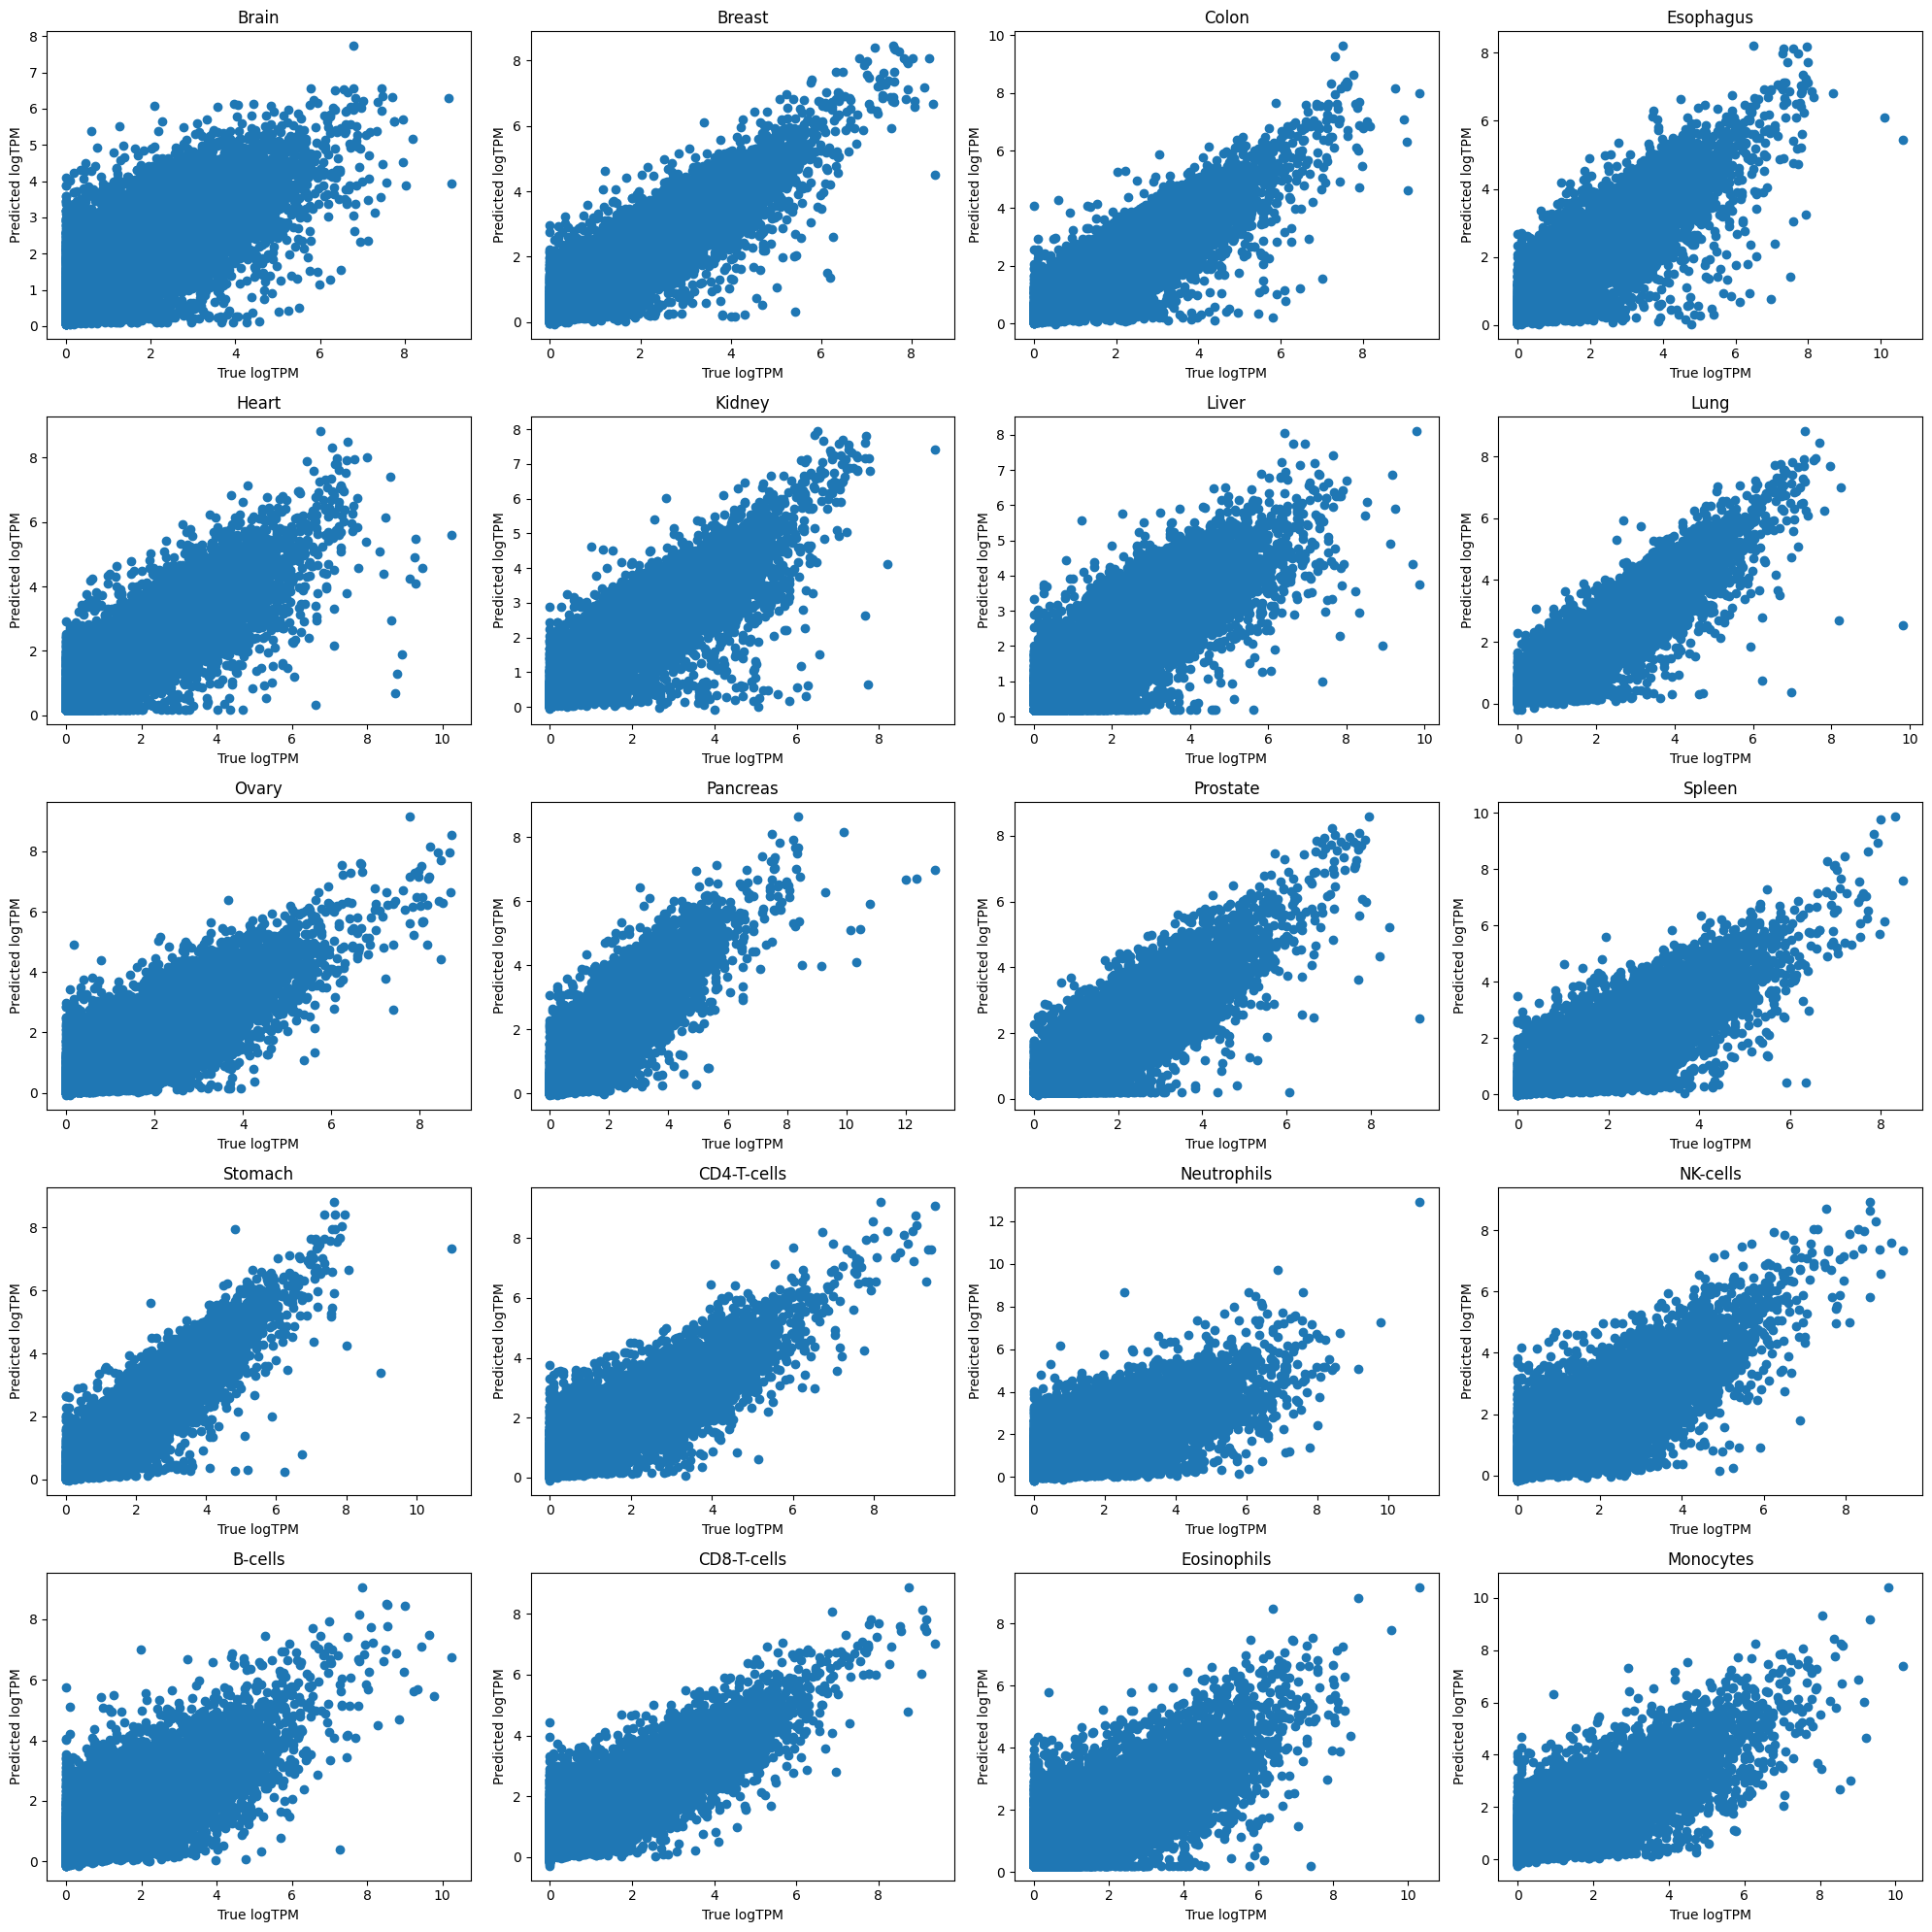

In [95]:


# model_name = "1kb_bins.new_data.leave_one_out.no_brain.mC_hmC.exp31"
model_name = "1kb_bins.new_data.leave_one_out.exp22"
predictions_file = f"{models_dir}{model_name}.model_predictions_df.csv"
preds_df = pd.read_csv(predictions_file)


df = preds_df

# Unique tissues
unique_tissues = df['tissue_x'].unique()

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(5, 4, figsize=(20, 20))

# Flatten the axes array for easy indexing
axs = axs.flatten()

for i, tissue in enumerate(unique_tissues):
    # Selecting only the rows corresponding to the current tissue
    tissue_data = df[df['tissue_x'] == tissue]

    # Plotting
    axs[i].scatter(tissue_data['logTPM'], tissue_data['model_preds'])
    axs[i].set_title(tissue)
    axs[i].set_xlabel('True logTPM')
    axs[i].set_ylabel('Predicted logTPM')

    # Break the loop if we've filled all subplots
    if i == 19:
        break

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
# model_name = "1kb_bins.leave_one_out.test12.exp2_overfit.lung"
# model_name = "1kb_bins.leave_one_out.exp14.overfit_deeper_net"
# model_name = "1kb_bins.new_data.all_tissues.exp24"
# model_name = "1kb_bins.new_data.leave_one_out.exp22.tissue_results.csv"
model_name = "2kb_bins.new_data.leave_one_out.exp23"
# model_name ="1kb_bins.new_data.leave_one_out.no_brain.exp26"
# model_name = "2kb_bins.new_data.leave_one_out.no_brain.exp27.tissue_results.csv"
# model_name = "1kb_bins.new_data.leave_one_out.no_brain.just_mC.exp28.tissue_results.csv"
models_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/dl_model/"

metrics_df = pd.read_csv(models_dir + f"{model_name}.tissue_results.csv",sep='\t').sort_values(by='Test R2',ascending=False)
plot_metrics_dl(metrics_df,plot_mae_mse=True)#.head()
test_predictions = pd.read_csv(models_dir + f"{model_name}.model_predictions_df.csv")
# plot_predictions_for_tissues_dl(['Lung','Liver','Pancreas','Kidney'], test_predictions, tissue_specific_df)

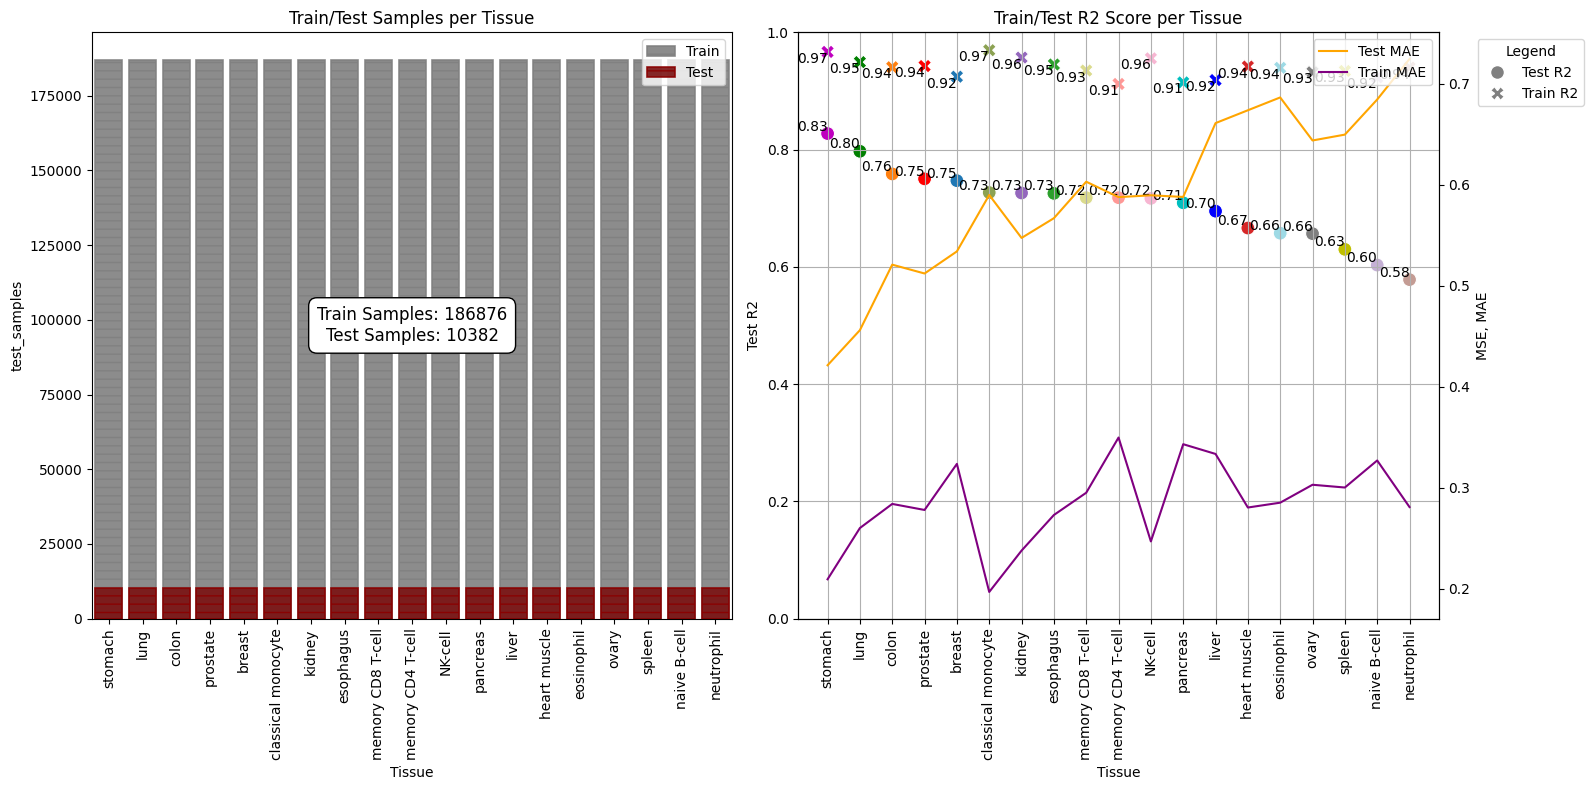

In [97]:
# model_name = "1kb_bins.leave_one_out.test12.exp2_overfit.lung"
# model_name = "1kb_bins.leave_one_out.exp14.overfit_deeper_net"
# model_name = "1kb_bins.new_data.all_tissues.exp24"
# model_name = "1kb_bins.new_data.leave_one_out.exp22.tissue_results.csv"
# model_name = "2kb_bins.new_data.leave_one_out.exp23"
model_name ="1kb_bins.new_data.leave_one_out.no_brain.exp26"
# model_name = "2kb_bins.new_data.leave_one_out.no_brain.exp27.tissue_results.csv"
# model_name = "1kb_bins.new_data.leave_one_out.no_brain.just_mC.exp28.tissue_results.csv"
models_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/dl_model/"

metrics_df = pd.read_csv(models_dir + f"{model_name}.tissue_results.csv",sep='\t').sort_values(by='Test R2',ascending=False)
plot_metrics_dl(metrics_df,plot_mae_mse=True)#.head()
test_predictions = pd.read_csv(models_dir + f"{model_name}.model_predictions_df.csv")
# plot_predictions_for_tissues_dl(['Lung','Liver','Pancreas','Kidney'], test_predictions, tissue_specific_df)

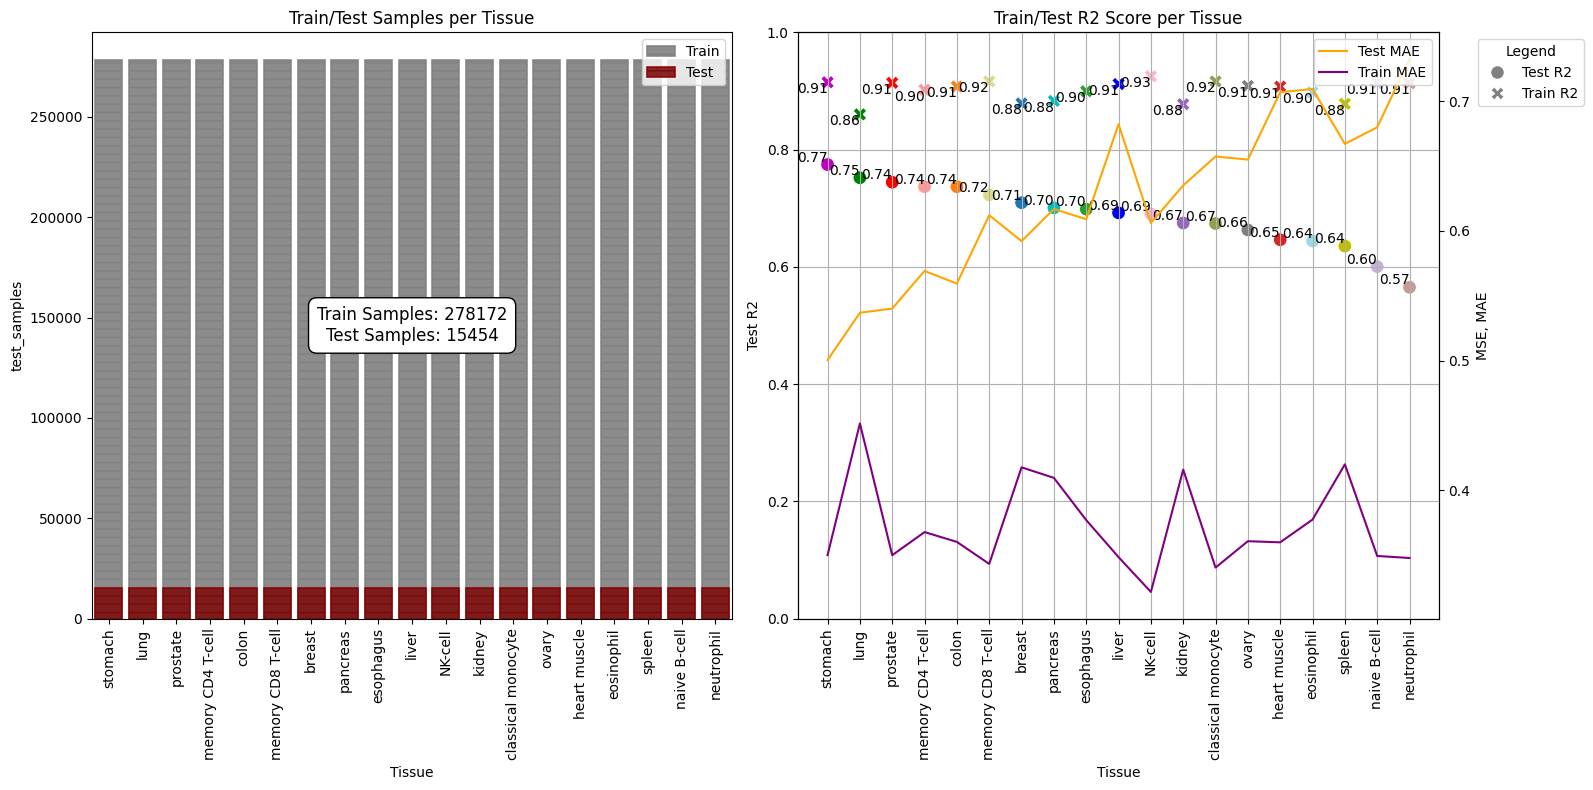

In [98]:
# model_name = "1kb_bins.leave_one_out.test12.exp2_overfit.lung"
# model_name = "1kb_bins.leave_one_out.exp14.overfit_deeper_net"
# model_name = "1kb_bins.new_data.all_tissues.exp24"
# model_name = "1kb_bins.new_data.leave_one_out.exp22.tissue_results.csv"
# model_name = "2kb_bins.new_data.leave_one_out.exp23"
# model_name ="1kb_bins.new_data.leave_one_out.no_brain.exp26"
model_name = "2kb_bins.new_data.leave_one_out.no_brain.exp27"
# model_name = "1kb_bins.new_data.leave_one_out.no_brain.just_mC.exp28.tissue_results.csv"
models_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/dl_model/"

metrics_df = pd.read_csv(models_dir + f"{model_name}.tissue_results.csv",sep='\t').sort_values(by='Test R2',ascending=False)
plot_metrics_dl(metrics_df,plot_mae_mse=True)#.head()
test_predictions = pd.read_csv(models_dir + f"{model_name}.model_predictions_df.csv")
# plot_predictions_for_tissues_dl(['Lung','Liver','Pancreas','Kidney'], test_predictions, tissue_specific_df)

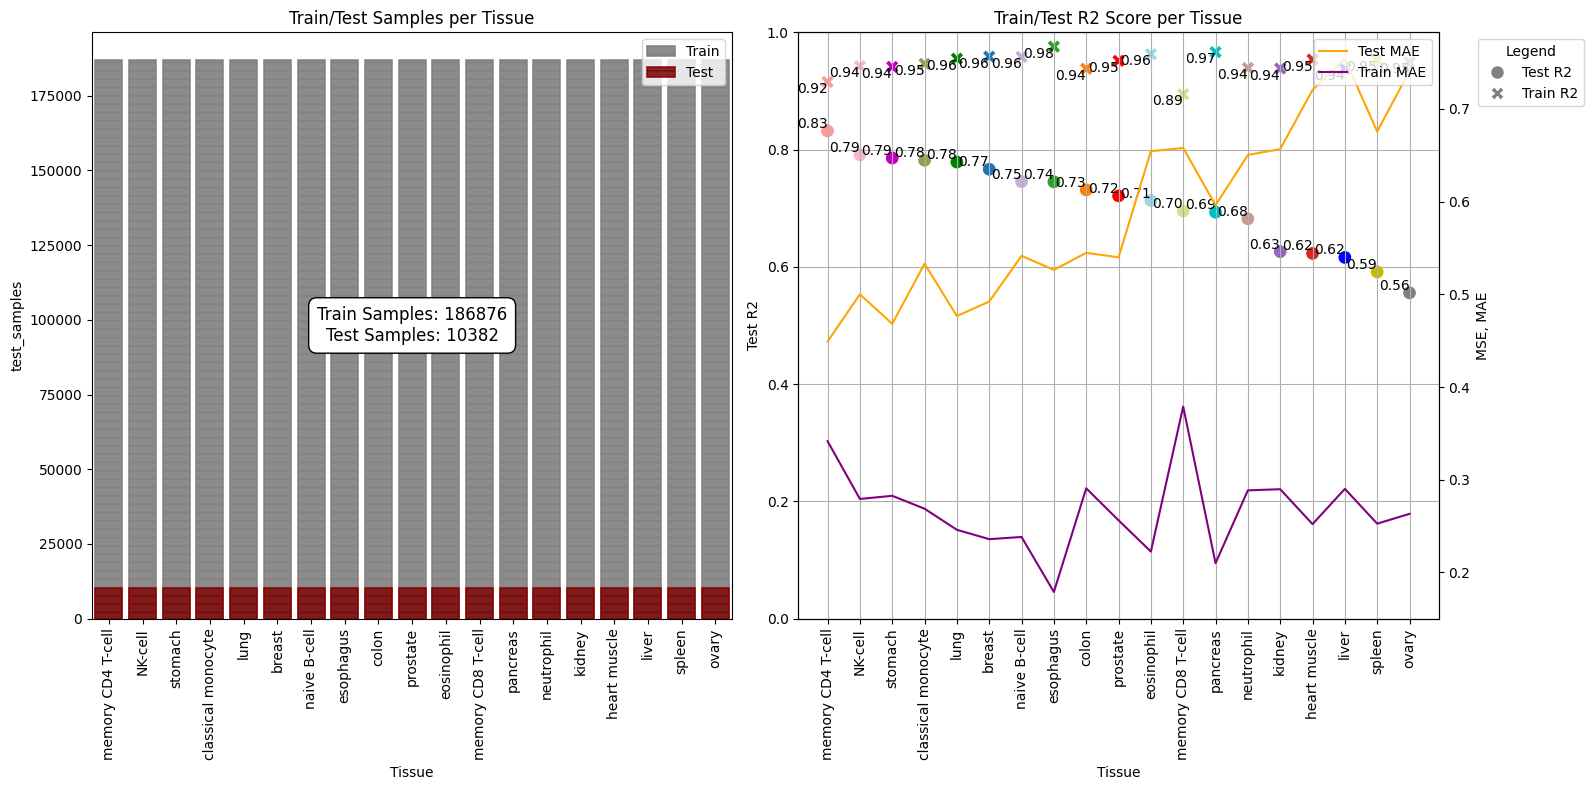

In [99]:
# model_name = "1kb_bins.leave_one_out.test12.exp2_overfit.lung"
# model_name = "1kb_bins.leave_one_out.exp14.overfit_deeper_net"
# model_name = "1kb_bins.new_data.all_tissues.exp24"
# model_name = "1kb_bins.new_data.leave_one_out.exp22.tissue_results.csv"
# model_name = "2kb_bins.new_data.leave_one_out.exp23"
# model_name ="1kb_bins.new_data.leave_one_out.no_brain.exp26"
# model_name = "2kb_bins.new_data.leave_one_out.no_brain.exp27"
model_name = "1kb_bins.new_data.leave_one_out.no_brain.just_mC.exp28"
models_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/dl_model/"

metrics_df = pd.read_csv(models_dir + f"{model_name}.tissue_results.csv",sep='\t').sort_values(by='Test R2',ascending=False)
plot_metrics_dl(metrics_df,plot_mae_mse=True)#.head()
test_predictions = pd.read_csv(models_dir + f"{model_name}.model_predictions_df.csv")
# plot_predictions_for_tissues_dl(['Lung','Liver','Pancreas','Kidney'], test_predictions, tissue_specific_df)

# Feature importance

### Load SHAP data from cluster

- There are two SHAP plots to make:

1) One from the All_Samples model, which shows feature use and polarity in the global model

2) The heatmap showing feature weight for each LOO tissue model



### All_Samples 1kb SHAPley importance

In [100]:
feature_importance_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/feature_importance/"

# shap_save_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/saved_models/"
shap_save_dir = feature_importance_dir
model_name = "1kb_bins.new_data.all_tissues.exp24."

shap_values_flat = np.load(os.path.join(shap_save_dir, f'{model_name}.shap_values.npy'))
test_data_sample_flat = np.load(os.path.join(shap_save_dir, f'{model_name}.test_data_sample_flat.npy'))
# plt.savefig(os.path.join(shap_save_dir, f'{model_name}.summary_plot.png'))

In [101]:
epigenetic_marks = ["mC", "hmC", "umC"]  # Methylation types
feature_names_flat = []

for i in range(3 * n_1kb_bins):
    mark = epigenetic_marks[i // n_1kb_bins]
    position = i % n_1kb_bins

    # For positions between TSS - 20kb and TSS + 20
    if position < 40:
        distance = abs(position - 20)
        if position >= 20:  # Positive TSS values without "kb"
            label = f"{mark}: TSS + {distance}"
        else:  # Negative TSS values with "kb"
            label = f"{mark}: TSS - {distance}kb"
    # For positions between TES + 0kb and TES + 20kb
    else:
        distance = position - 40
        label = f"{mark}: TES + {distance}kb"

    feature_names_flat.append(label)

In [102]:
feature_names_flat

['mC: TSS - 20kb',
 'mC: TSS - 19kb',
 'mC: TSS - 18kb',
 'mC: TSS - 17kb',
 'mC: TSS - 16kb',
 'mC: TSS - 15kb',
 'mC: TSS - 14kb',
 'mC: TSS - 13kb',
 'mC: TSS - 12kb',
 'mC: TSS - 11kb',
 'mC: TSS - 10kb',
 'mC: TSS - 9kb',
 'mC: TSS - 8kb',
 'mC: TSS - 7kb',
 'mC: TSS - 6kb',
 'mC: TSS - 5kb',
 'mC: TSS - 4kb',
 'mC: TSS - 3kb',
 'mC: TSS - 2kb',
 'mC: TSS - 1kb',
 'mC: TSS + 0',
 'mC: TSS + 1',
 'mC: TSS + 2',
 'mC: TSS + 3',
 'mC: TSS + 4',
 'mC: TSS + 5',
 'mC: TSS + 6',
 'mC: TSS + 7',
 'mC: TSS + 8',
 'mC: TSS + 9',
 'mC: TSS + 10',
 'mC: TSS + 11',
 'mC: TSS + 12',
 'mC: TSS + 13',
 'mC: TSS + 14',
 'mC: TSS + 15',
 'mC: TSS + 16',
 'mC: TSS + 17',
 'mC: TSS + 18',
 'mC: TSS + 19',
 'mC: TES + 0kb',
 'mC: TES + 1kb',
 'mC: TES + 2kb',
 'mC: TES + 3kb',
 'mC: TES + 4kb',
 'mC: TES + 5kb',
 'mC: TES + 6kb',
 'mC: TES + 7kb',
 'mC: TES + 8kb',
 'mC: TES + 9kb',
 'mC: TES + 10kb',
 'mC: TES + 11kb',
 'mC: TES + 12kb',
 'mC: TES + 13kb',
 'mC: TES + 14kb',
 'mC: TES + 15kb',
 'mC:

Dimensions match, proceeding to summary_plot.


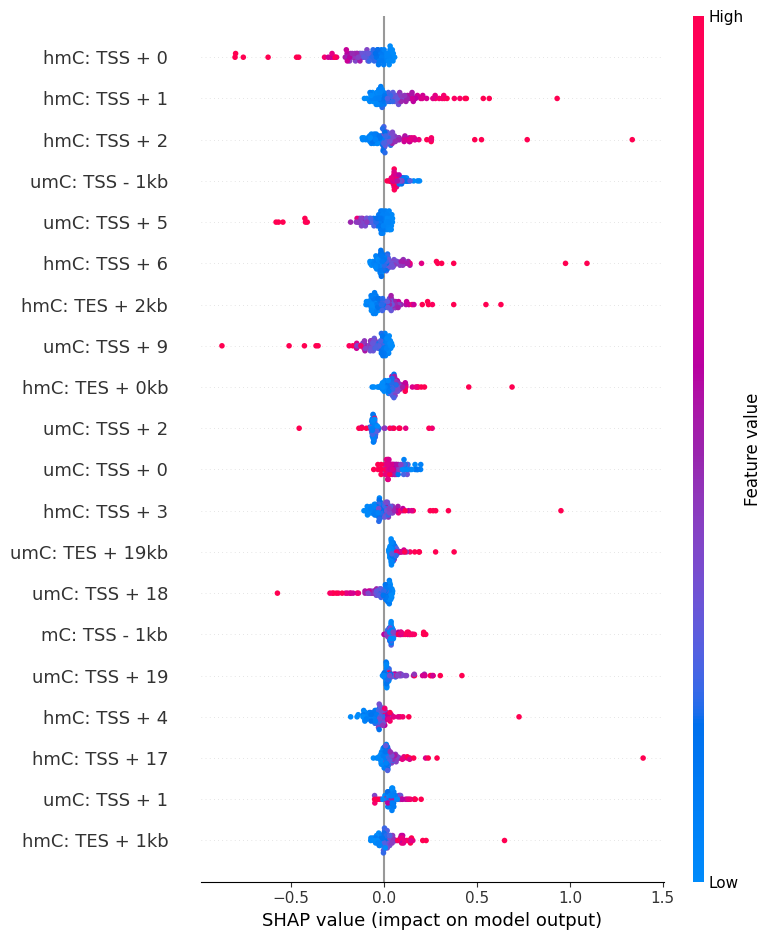

In [103]:

n_epigenetic_cols = 3
n_1kb_bins = 60

# Initialize JavaScript for SHAP plots
shap.initjs()

# Create feature names for the flattened array
# feature_names_flat = [f"Epigenetic_Mark_{i//40}_Position_{i%40}" for i in range(120)]
# feature_names_flat = [f"Epigenetic_Mark_{i//n_1kb_bins}_Position_{i%n_1kb_bins}" for i in range(3*n_1kb_bins)]

epigenetic_marks = ["mC", "hmC", "umC"]  # Methylation types
# feature_names_flat = [f"{epigenetic_marks[i // n_1kb_bins]}: TSS{'+ ' if i % n_1kb_bins >= 20 else '- '}{abs(i % n_1kb_bins - 20)}kb" for i in range(3 * n_1kb_bins)]

# Check if both have the same number of rows just before calling summary_plot
if shap_values_flat.shape[0] == test_data_sample_flat.shape[0]:
    print("Dimensions match, proceeding to summary_plot.")
    try:
        # Attempt to plot
        shap.summary_plot(shap_values_flat, test_data_sample_flat, feature_names=feature_names_flat)
    except Exception as e:
        print(f"An exception occurred: {e}")
else:
    print("Dimensions mismatch")

### All_Samples 2kb SHAPley importance

Dimensions match, proceeding to summary_plot.


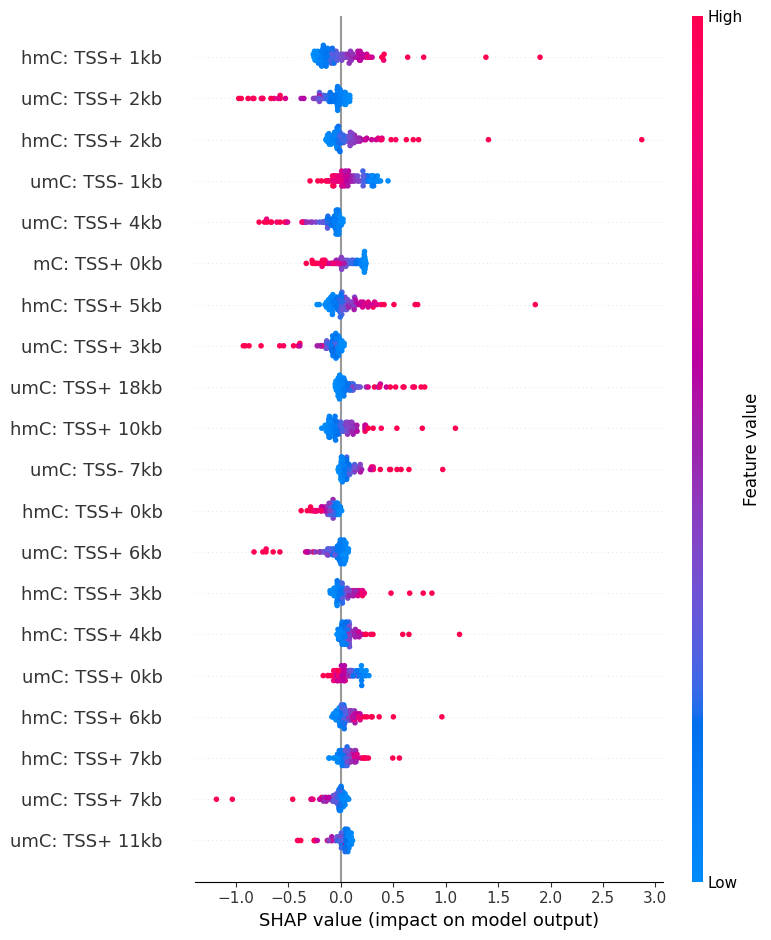

In [104]:
feature_importance_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/feature_importance/"

# shap_save_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/saved_models/"
shap_save_dir = feature_importance_dir
model_name = "2kb_bins.new_data.all_tissues.exp25."

shap_values_flat = np.load(os.path.join(shap_save_dir, f'{model_name}.shap_values.npy'))
test_data_sample_flat = np.load(os.path.join(shap_save_dir, f'{model_name}.test_data_sample_flat.npy'))
# plt.savefig(os.path.join(shap_save_dir, f'{model_name}.summary_plot.png'))



n_epigenetic_cols = 3
n_1kb_bins = 30

# Initialize JavaScript for SHAP plots
shap.initjs()

# Create feature names for the flattened array
# feature_names_flat = [f"Epigenetic_Mark_{i//40}_Position_{i%40}" for i in range(120)]
# feature_names_flat = [f"Epigenetic_Mark_{i//n_1kb_bins}_Position_{i%n_1kb_bins}" for i in range(3*n_1kb_bins)]

epigenetic_marks = ["mC", "hmC", "umC"]  # Methylation types
feature_names_flat = [f"{epigenetic_marks[i // n_1kb_bins]}: TSS{'+ ' if i % n_1kb_bins >= 10 else '- '}{abs(i % n_1kb_bins - 10)}kb" for i in range(3 * n_1kb_bins)]

# Check if both have the same number of rows just before calling summary_plot
if shap_values_flat.shape[0] == test_data_sample_flat.shape[0]:
    print("Dimensions match, proceeding to summary_plot.")
    try:
        # Attempt to plot
        shap.summary_plot(shap_values_flat, test_data_sample_flat, feature_names=feature_names_flat)
    except Exception as e:
        print(f"An exception occurred: {e}")
else:
    print("Dimensions mismatch")

### LOO models 1kb heatmap

In [108]:
rna_seq_values_df = pd.read_csv(save_dir +  data_load_name + f"gene_tissue_combinations_rnaseq.csv",sep='\t')

tissues_processed = rna_seq_values_df['rna_seq_tissue'].unique()

In [109]:
rna_seq_values_df

,Unnamed: 0,original_index,core_gene_x,tissue_x,rna_seq_tissue,core_gene_y,Name,Description,tissue_y,TPM,logTPM,Normalized_TPM,log_Normalized_TPM
0,0,0,SAMD11,Brain,midbrain,ENSG00000187634,ENSG00000187634,SAMD11,midbrain,10.5,2.442347,0.122362,0.115436
1,1,1,SAMD11,Breast,breast,ENSG00000187634,ENSG00000187634,SAMD11,breast,1.8,1.029619,0.035870,0.035242
2,2,2,SAMD11,Colon,colon,ENSG00000187634,ENSG00000187634,SAMD11,colon,4.9,1.774952,0.077844,0.074963
3,3,3,SAMD11,Esophagus,esophagus,ENSG00000187634,ENSG00000187634,SAMD11,esophagus,1.9,1.064711,0.032602,0.032082
4,4,4,SAMD11,Heart,heart muscle,ENSG00000187634,ENSG00000187634,SAMD11,heart muscle,13.2,2.653242,0.079609,0.076599
...,...,...,...,...,...,...,...,...,...,...,...,...,...
207635,207635,208515,VAMP7,NK-cells,NK-cell,ENSG00000124333,ENSG00000124333,VAMP7,NK-cell,22.7,3.165475,0.580954,0.458029
207636,207636,208516,VAMP7,B-cells,naive B-cell,ENSG00000124333,ENSG00000124333,VAMP7,naive B-cell,13.2,2.653242,0.234397,0.210583
207637,207637,208517,VAMP7,CD8-T-cells,memory CD8 T-cell,ENSG00000124333,ENSG00000124333,VAMP7,memory CD8 T-cell,18.6,2.975530,0.453019,0.373643
207638,207638,208518,VAMP7,Eosinophils,eosinophil,ENSG00000124333,ENSG00000124333,VAMP7,eosinophil,39.6,3.703768,0.787419,0.580773


In [110]:
gene_name_id_map = {}

gene_name_id_map = rna_seq_values_df.set_index('Description')['Name'].to_dict()
gene_id_name_map = rna_seq_values_df.set_index('Name')['Description'].to_dict()

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_1kb_shap_heatmaps(mean_shap_values_dict, tissues, positions=60, savename=None):
    # Set up the gridspec with 3 rows for each mark_name and two columns for the heatmap and the red line
#     fig = plt.figure(figsize=(12, len(tissues) * 1.5))
    fig = plt.figure(figsize=(8, 16))
    outer_grid = gridspec.GridSpec(3, 1, height_ratios=[1 for _ in mean_shap_values_dict], hspace=0.3)

    # Updated custom_labels with TES+ labels
#     custom_labels = ['' for _ in range(positions)]
#     for i in range(0, positions, 5):
#         if i < 20:
#             custom_labels[i] = 'TSS - {}kb'.format(20 - i)
#         elif i == 20:
#             custom_labels[i] = 'TSS'
#         elif i <= 39:
#             custom_labels[i] = 'TSS + {}'.format(i - 20)
            
#         elif i==40:
#             custom_labels[i] = 'TES'.format(i - 20)
#         else:
#             custom_labels[i] = 'TES + {}kb'.format(i - 40)  # Labels for positions after TES




    custom_labels = ['' for _ in range(positions)]
    for i in range(0, positions, 5):
        if i < 20:
            custom_labels[i] = '-{}kb'.format(20 - i)
        elif i == 20:
            custom_labels[i] = 'TSS'
        elif i <= 39:
            custom_labels[i] = '+{}'.format(i - 20)
            
        elif i==40:
            custom_labels[i] = 'TES'.format(i - 20)
        else:
            custom_labels[i] = '+{}kb'.format(i - 40)  # Labels for positions after TES

    for idx, (mark_name, mean_shap_values) in enumerate(mean_shap_values_dict.items()):
        # Create an inner grid for each row
        inner_grid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_grid[idx], height_ratios=[1, 20], hspace=0)
        # Add a subplot for the red line
        ax0 = fig.add_subplot(inner_grid[0])
#         print((20.5/positions))
#         print((40.5/positions))
#         ax0.axhline(y=0.5, xmin=(20.5/positions), xmax=(40.5/positions), color='red', linestyle='-', linewidth=2)
#         ax0.axhline(y=0.5, xmin=(0.3), xmax=(0.4), color='red', linestyle='-', linewidth=2)

        tss_pos = 20  # Assuming TSS is always at position 20
        tes_pos = 40  # Assuming TES is always at position 40

        # Add the red line between TSS and TES
        ax0.axhline(y=0.3, xmin=(0.28), xmax=(0.54), color='red', linestyle='-', linewidth=2)


        ax0.set_xlim(0, positions)
        ax0.axis('off')

        # Add a subplot for the heatmap
        ax = fig.add_subplot(inner_grid[1])
        cax = ax.matshow(mean_shap_values, cmap='viridis', aspect='auto')
#         cbar = fig.colorbar(cax, ax=ax, orientation='vertical', label="Mean Absolute SHAP Value", shrink=0.5)
        cbar = fig.colorbar(cax, ax=ax, orientation='vertical', shrink=0.5)
#         cbar.ax.tick_params(labelrotation=0)
        ax.set_title(f"Mean absolute SHAP value for {mark_name}")
#         ax.set_ylabel("Tissue")
        ax.set_ylabel("")
        ax.set_xticks(np.arange(0, positions, 1))
        ax.xaxis.tick_bottom()
        ax.set_xticklabels(custom_labels, rotation=90)
#         ax.set_xticklabels(custom_labels, rotation=0)

#         if idx==2:
#             ax.set_xticklabels(custom_labels, rotation=90)
#         else:
#             ax.set_xticklabels([])
        ax.set_yticks(np.arange(len(tissues)))
        ax.set_yticklabels(tissues)

        # Set up secondary axis for TSS and TES labels on the heatmap
        ax2 = ax.secondary_xaxis('top')
        ax2.set_xticks([20, 40])
        ax2.set_xticklabels(['TSS', 'TES'])

    plt.tight_layout()
    if savename:
        plt.savefig(savename)
#     plt.show()

# Call the function with the appropriate data
# plot_all_shap_heatmaps(mean_shap_values_dict, tissues, positions=60, savename=None)


In [206]:
tissue_name_mapping = {
    'midbrain':"Brain",
    'stomach': 'Stomach',
    'memory CD4 T-cell': 'CD4-T-cells',
    'lung': 'Lung',
    'pancreas': 'Pancreas',
    'liver': 'Liver',
    'memory CD8 T-cell': 'CD8-T-cells',
    'eosinophil': 'Eosinophils',
    'colon': 'Colon',
    'prostate': 'Prostate',
    'classical monocyte': 'Monocytes',
    'breast': 'Breast',
    'kidney': 'Kidney',
    'NK-cell': 'NK-cells',
    'esophagus': 'Esophagus',
    'spleen': 'Spleen',
    'ovary': 'Ovary',
    'heart muscle': 'Heart',
    'naive B-cell': 'B-cells',
    'neutrophil': 'Neutrophils'
}

In [207]:
tissues_proper_names = [tissue_name_mapping[u] for u in tissues_processed[0:-1]]

In [208]:
tissues_processed

array(['midbrain', 'breast', 'colon', 'esophagus', 'heart muscle',
       'kidney', 'liver', 'lung', 'ovary', 'pancreas', 'prostate',
       'spleen', 'stomach', 'memory CD4 T-cell', 'neutrophil', 'NK-cell',
       'naive B-cell', 'memory CD8 T-cell', 'eosinophil',
       'classical monocyte'], dtype=object)

In [209]:
fig_savedir = "/well/ludwig/users/dyp502/thesis/thesis_figures/ge_predict/"

# plt.savefig(fig_savedir + f"Best_1kb_model.cancer_preds.pearson_correlation_zscore.{model_name}.thesis_clean.png",
#            dpi=300)

fig_savename = fig_savedir + f"Best_1kb_model.SHAP_feature_importance_heatmap.{model_name}.thesis_clean.png"



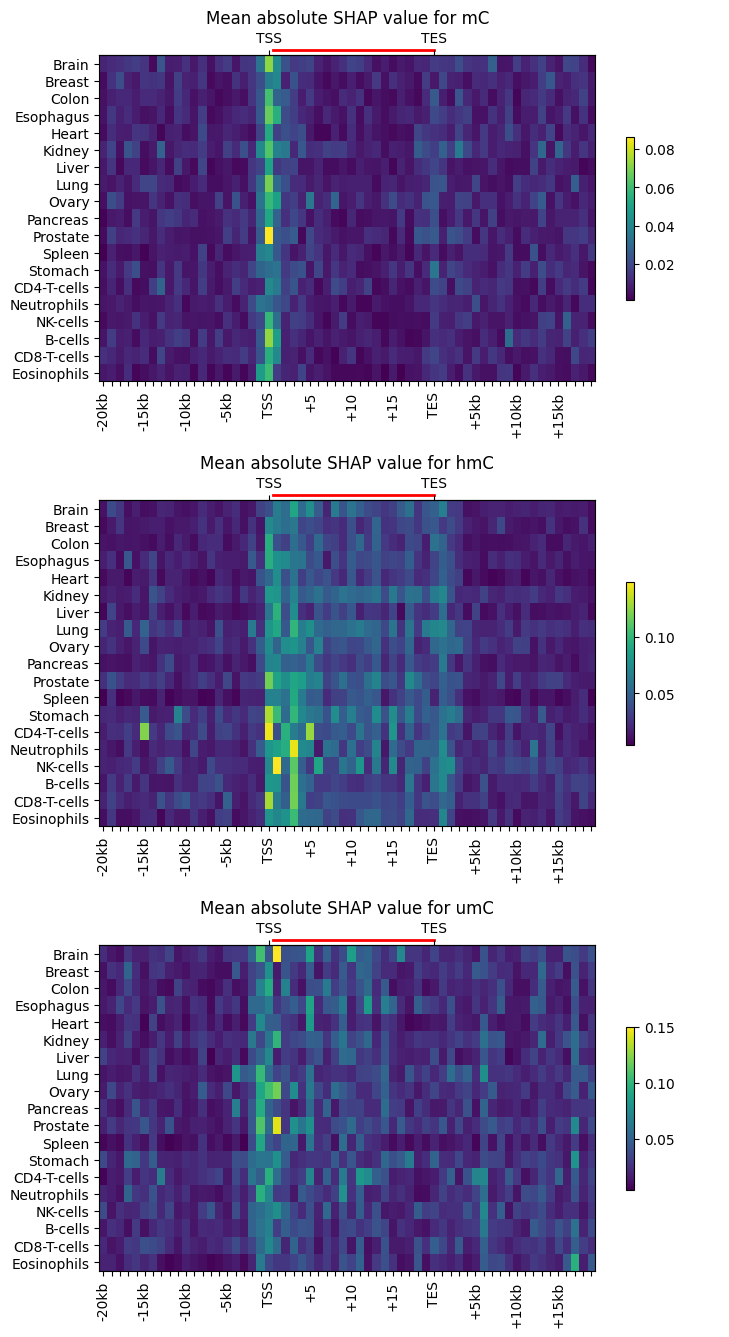

In [210]:
feature_importance_dir = "/well/ludwig/users/dyp502/tissue_atlas_v3/predict_ge/1kb_model/feature_importance/"
model_name = "1kb_bins.new_data.leave_one_out.no_brain.exp26." # after switching order for - strand genes


with open(feature_importance_dir + f"{model_name}.mean_shap_values_dict.pkl", 'rb') as file:
    mean_shap_values_dict = pickle.load(file)
    
# plot_1kb_shap_heatmaps(mean_shap_values_dict, tissues_processed[0:-1],
# #                        savename=feature_importance_dir + f"SHAP_heatmap.{model_name}.png",
#                       )

plot_1kb_shap_heatmaps(mean_shap_values_dict, tissues_proper_names,
                       savename=fig_savename,
#                        savename=feature_importance_dir + f"SHAP_heatmap.{model_name}.png",
                      )


### LOO models 2kb heatmap

In [116]:
mean_shap_values_dict['mC'].shape

(19, 30)

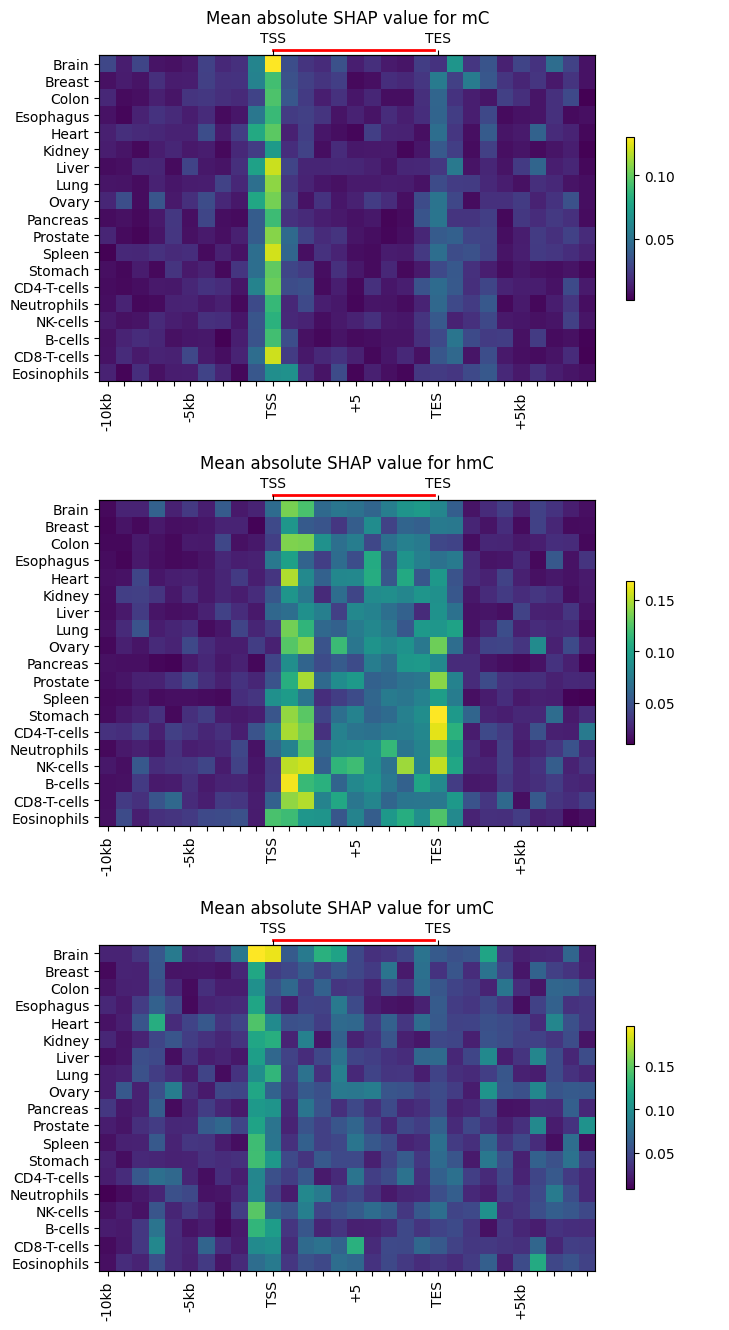

In [217]:
model_name = "2kb_bins.new_data.leave_one_out.no_brain.exp27." # just for long job - identical as exp21

with open(feature_importance_dir + f"{model_name}mean_shap_values_dict.pkl", 'rb') as file:
    mean_shap_values_dict = pickle.load(file)
# Plotting the heatmaps as subplots
# plot_all_shap_heatmaps(mean_shap_values_dict, tissues_processed,savename=feature_importance_dir + f"SHAP_heatmap.{model_name}.png")


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_2kb_shap_heatmaps(mean_shap_values_dict, tissues, positions=30, savename=None):
    # Set up the gridspec with 3 rows for each mark_name and two columns for the heatmap and the red line
#     fig = plt.figure(figsize=(12, len(tissues) * 1.5))
    fig = plt.figure(figsize=(8, 16))
    outer_grid = gridspec.GridSpec(3, 1, height_ratios=[1 for _ in mean_shap_values_dict], hspace=0.3)

#     # Updated custom_labels with TES+ labels
#     custom_labels = ['' for _ in range(positions)]
#     for i in range(0, positions, 5):
#         if i < 10:
#             custom_labels[i] = 'TSS - {}kb'.format(10 - i)
#         elif i == 10:
#             custom_labels[i] = 'TSS'
#         elif i <= 19:
#             custom_labels[i] = 'TSS + {}'.format(i - 10)
            
#         elif i==20:
#             custom_labels[i] = 'TES'.format(i - 20)
#         else:
#             custom_labels[i] = 'TES + {}kb'.format(i - 20)  # Labels for positions after TES


    # Updated custom_labels with TES+ labels
    custom_labels = ['' for _ in range(positions)]
    for i in range(0, positions, 5):
        if i < 10:
            custom_labels[i] = '-{}kb'.format(10 - i)
        elif i == 10:
            custom_labels[i] = 'TSS'
        elif i <= 19:
            custom_labels[i] = '+{}'.format(i - 10)
            
        elif i==20:
            custom_labels[i] = 'TES'.format(i - 20)
        else:
            custom_labels[i] = '+{}kb'.format(i - 20)  # Labels for positions after TES


    for idx, (mark_name, mean_shap_values) in enumerate(mean_shap_values_dict.items()):
        # Create an inner grid for each row
        inner_grid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_grid[idx], height_ratios=[1, 20], hspace=0)
        # Add a subplot for the red line
        ax0 = fig.add_subplot(inner_grid[0])
#         print((20.5/positions))
#         print((40.5/positions))
#         ax0.axhline(y=0.5, xmin=(20.5/positions), xmax=(40.5/positions), color='red', linestyle='-', linewidth=2)
#         ax0.axhline(y=0.5, xmin=(0.3), xmax=(0.4), color='red', linestyle='-', linewidth=2)

        tss_pos = 20  # Assuming TSS is always at position 20
        tes_pos = 40  # Assuming TES is always at position 40

        # Add the red line between TSS and TES
        ax0.axhline(y=0.3, xmin=(0.28), xmax=(0.54), color='red', linestyle='-', linewidth=2)


        ax0.set_xlim(0, positions)
        ax0.axis('off')

        # Add a subplot for the heatmap
        ax = fig.add_subplot(inner_grid[1])
        cax = ax.matshow(mean_shap_values, cmap='viridis', aspect='auto')
#         fig.colorbar(cax, ax=ax, orientation='vertical', label="Mean Absolute SHAP Value", shrink=0.5)
        fig.colorbar(cax, ax=ax, orientation='vertical', shrink=0.5)
#         ax.set_title(f"Mean Absolute SHAP Value Heatmap for {mark_name} Across Tissues")
        ax.set_title(f"Mean absolute SHAP value for {mark_name}")
#         ax.set_ylabel("Tissue")
        ax.set_ylabel("")
        ax.set_xticks(np.arange(0, positions, 1))
        ax.xaxis.tick_bottom()
        ax.set_xticklabels(custom_labels, rotation=90)
        ax.set_yticks(np.arange(len(tissues)))
        ax.set_yticklabels(tissues)

        # Set up secondary axis for TSS and TES labels on the heatmap
        ax2 = ax.secondary_xaxis('top')
        ax2.set_xticks([10, 20])
        ax2.set_xticklabels(['TSS', 'TES'])

    plt.tight_layout()
    if savename:
        plt.savefig(savename)
    plt.show()

    
fig_savename = fig_savedir + f"Best_2kb_model.SHAP_feature_importance_heatmap.{model_name}.thesis_clean.png"

    
plot_2kb_shap_heatmaps(mean_shap_values_dict, tissues_proper_names,
                       savename=fig_savename,
                      )